# Pistachio simulation

<!-- Index of contents -->
* [Define the problem](#Define-the-problem)
* [Simulation agents](#Simulation-agents)
* [Stress types](#Stress-types)
  * [Chill hours stress](#Chill-hours-stress)
  * [Heat units stress](#Heat-units-stress)
  * [Temperature stress](#Temperature-stress)
  * [Hydric stress](#Hydric-stress)
* [Simulation parameters](#Simulation-parameters)

## Define the problem

......

## Simulation agents

In [5]:
from pydantic import BaseModel, Field, field_validator, model_validator
from typing import List, Literal, Optional
from datetime import date
import numpy as np
from typing import Tuple

from enum import Enum

class IntensityLevel(List[float], Enum):
    low = [0.1, 0.3]
    medium = [0.3, 0.6]
    high = [0.6, 0.8]
    very_high = [0.8, 1.0]

### Weather agent

In [6]:
# Meteorological Class
import datetime
import time


class Meteorological(BaseModel):
    timestamp: date
    t_med: float = Field(..., ge=-30, le=50, description="Current temperature [-30°C to 50°C]")
    t_min: float = Field(..., ge=-30, le=50, description="Minimum temperature [-30°C to 50°C]")
    t_max: float = Field(..., ge=-30, le=50, description="Maximum temperature [-30°C to 50°C]")
    rh_med: float = Field(..., ge=0, le=100, description="Current relative humidity [0-100%]")
    rh_min: float = Field(..., ge=0, le=100, description="Minimum relative humidity [0-100%]")
    rh_max: float = Field(..., ge=0, le=100, description="Maximum relative humidity [0-100%]")
    wind: float = Field(..., ge=0, description="Current wind speed [0-.. m/s]")
    pp: float = Field(..., ge=0, description="Precipitation level [0-.. mm]")

# Weather Class
class Weather(BaseModel):
    # Input variables
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    init_date: date = Field(..., description="Initial date")
    end_date: date = Field(..., description="End date")
    available_init_date: date = Field(..., description="Available initial date")
    available_end_date: date = Field(..., description="Available end date")
    type: Literal["normal", "extreme"] = Field(..., description="Type of weather [normal, extreme]")
    # Local variables
    meteorological: List[Meteorological] = Field(default=[], description="List of meteorological data")

    def transform_meteorological_data(self):
        match self.type:
            case "extreme":
                # NOTE: This is a dummy example, in a real case
                for meteorological in self.meteorological:
                    meteorological.temperature += np.random.choice([-5, 5])
                    meteorological.relative_humidity += np.random.choice([-10, 10])
                    meteorological.wind += np.random.choice([-10, 10])
                    meteorological.precipitation += np.random.choice([-10, 10])

    @property
    def idema(self):
        # TODO:
        return "2503B" # Idema de Olmedo, depósito de agua, la estación más cercana a Pozal de Gallinas (https://datosclima.es/Aemethistorico/Estaciones.php)
    
    def generate_random_weather_data(self) -> List[Meteorological]:
        if self.init_date.year == self.available_init_date.year and self.end_date.year == self.available_end_date.year:
            return self.meteorological
        '''Generate random distribution of meteorological data over init_date and end_date'''
        import random
        import copy
        # self.meteorological_by_year = [[year1_data], [year2_data], ...]
        meteorological_by_year = [[]]
        for i, data in enumerate(self.meteorological):
                if i != 0 and self.meteorological[i-1].timestamp.month == 12 and data.timestamp.month == 1:
                    meteorological_by_year.append([]) # New year
                meteorological_by_year[-1].append(data)
        # Generate random data
        years = self.end_date.year - self.init_date.year + 1 # Number of years to generate
        new_meteorological = random.choices(meteorological_by_year, k=years)
        # Change every timestamp to the new year
        updated_meteorological = []
        for i in range(years):
            selected_year_data = new_meteorological[i]
            copied_year_data = copy.deepcopy(selected_year_data) # This is to avoid reference problems
            new_year = self.init_date.year + i
            for data in copied_year_data:
                try:
                    data.timestamp = data.timestamp.replace(year=new_year)
                except ValueError:
                        data.timestamp = data.timestamp.replace(year=new_year, day=28)

            updated_meteorological.extend(copied_year_data)
        # Sort list
        updated_meteorological.sort(key=lambda x: x.timestamp)
        self.meteorological = updated_meteorological
        return self.meteorological

    def get_weather_data(self):
        import dotenv
        import os
        import requests_cache

        def safe_float(value, default=0.0):
            try:
                return float(value.replace(",", "."))
            except ValueError:
                return default

        dotenv.load_dotenv()
        weather_url = os.getenv("AGROSLAB_API_URL")
        AUTH_TOKEN = os.getenv("AGROSLAB_AUTH_TOKEN")

        headers = {
            'Authorization': AUTH_TOKEN,
        }
        # Loop data every 4 months because the API has a limit of 6 months
        init_date = self.available_init_date
        end_date = self.available_end_date
        while init_date < end_date:
            end_date_query = init_date + datetime.timedelta(days=4 * 30)
            if end_date_query > end_date:
                end_date_query = end_date
            body = {
                "operation": "aemetclimatologiadiaria",
                "initdate": init_date.strftime("%d-%m-%Y"),
                "enddate": end_date_query.strftime("%d-%m-%Y"),
                "idema": self.idema
            }
            cache_name = f"cache/cache_{self.idema}_{init_date.strftime('%Y%m%d')}_{end_date_query.strftime('%Y%m%d')}"
            if not os.path.exists(f"{cache_name}.sqlite"):
                time.sleep(3)
            session = requests_cache.CachedSession(cache_name, allowable_methods=('GET', 'POST'))
            data = session.post(weather_url, json=body, headers=headers)
            if data.status_code != 200:
                raise ValueError(data.json())
            historical_data_raw = data.json()
            # Process
            # tmed, velmedia, tmin, tmax, prec, date, hrMedia, hrMax, hrMin
            historical_data = []
            for data in historical_data_raw:
                meteorological = Meteorological(
                    timestamp=date.fromisoformat(data["fecha"]),
                    t_med=safe_float(data.get("tmed", "0")),
                    t_min=safe_float(data.get("tmin", "0")),
                    t_max=safe_float(data.get("tmax", "0")),
                    rh_med=safe_float(data.get("hrMedia", "40")),
                    rh_min=safe_float(data.get("hrMin", "0")),
                    rh_max=safe_float(data.get("hrMax", "0")),
                    wind=safe_float(data.get("velmedia", "0")),
                    pp=safe_float(data.get("prec", "0"))
                )
                historical_data.append(meteorological)
            # value
            self.meteorological.extend(historical_data) 
            init_date = init_date + datetime.timedelta(days=4 * 30 + 1)
        return self.meteorological

### Disease agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Disease          | Temperature       | Humidity     | Severity   | Treatment difficulty | Period               |
|------------------|-------------------|--------------|------------|-----------------------|----------------------|
| Verticillium     | $20 - 30^{\circ}C$ | Better high  | Very high  | Very high            | June - September     |
| Botryosphaeria   | $27 - 33^{\circ}C$ | Better high  | High       | Medium               | June - September     |
| Alternaria       | $27 - 35^{\circ}C$ | Better high  | Medium     | Medium               | mid July - September |
| Septoria         | $18 - 26^{\circ}C$ | Better high  | High       | Medium               | May - September      |
| Aflatoxins       | $27 - 40^{\circ}C$ | Better high  | Very High  | High                 | Mid August - Harvest |


In [7]:
from enum import Enum

class DiseaseType(str, Enum):
    Verticillium = "Verticillium"
    Botryosphaeria = "Botryosphaeria"
    Alternaria = "Alternaria"
    Septoria = "Septoria"
    Aflatoxin = "Aflatoxin"

class Disease(BaseModel):
    type: DiseaseType = Field(..., description="Type of disease, e.g., Verticillium, Alternaria")
    RH_disease_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for disease")
    T_disease_min: float = Field(..., ge=0, le=50, description="Minimum temperature for disease")
    T_disease_max: float = Field(..., ge=0, le=50, description="Maximum temperature for disease")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of the disease [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the disease can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the disease disappears")

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        if period_end < values['period_init']:
            raise ValueError('period_end must be greater than period_init')
        return period_end


### Pest agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Pest               | Temperature       | Humidity     | Severity | Treatment difficulty | Period             |
|--------------------|-------------------|--------------|----------|-----------------------|--------------------|
| Green stink bug    | $20 - 35^{\circ}C$ | Better high  | Medium   | High                 | August - October   |
| Pistachio psylla   | $20 - 35^{\circ}C$ | Better high  | High     | High                 | April - October    |
| Leaf beetle        | $20 - 35^{\circ}C$ | Better high  | Low      | Medium               | May                |

In [8]:
from enum import Enum

class PestType(str, Enum):
    green_stink_bug = "Green stink bug"
    pistachio_psylla = "Pistachio psylla"
    leaf_beetle = "Leaf beetle"

class Pest(BaseModel):
    type: PestType = Field(..., description="Type of pest, e.g., Green stink bug, Leaf beetle")
    RH_pest_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for pest activity")
    T_pest_min: float = Field(..., ge=0, le=50, description="Minimum temperature for pest activity")
    T_pest_max: float = Field(..., ge=0, le=50, description="Maximum temperature for pest activity")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of pest [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the pest can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the pest disappears")

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        if 'period_init' in values and period_end < values['period_init']:
            raise ValueError("period_end must be after period_init")
        return period_end


### Farm agent

In [9]:
class Farm(BaseModel):
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Type of irrigation [drip, sprinkler]")

class Soil(BaseModel):
    drainage: float = Field(..., ge=0.0, le=1.0, description="Drainage quality [low=0.0, high=1.0]")

### Crop agent

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

#### Rootstock

| **Characteristic**                 | **Rootstocks (in order of preference)**                                                                                  |
|------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| Cold Resistance                    | *P. Cornicabra (or P. Terebinthus)*, *P. Atlantica*                                                                       |
| Resistance to Verticillium         | *P. Integerrima (PGI)*, UCB-1                                                                                            |
| Salinity Resistance                | *P. Atlantica*, *P. Cornicabra*                                                                                          |
| Good Productivity in Poor Soils    | *P. Cornicabra*, *P. Vera*                                                                                               |
| High Yield                         | UCB-1, *P. Integerrima*, *P. Atlantica*, *P. Cornicabra*                                                                 |
| High Vigor (Trunk Diameter)        | *P. Atlantica*, *P. Cornicabra*, *P. Integerrima*, *P. Vera*                                                             |
| Recommended for Dryland Farming    | *P. Cornicabra*                                                                                                          |
| Recommended for Irrigated Farming  | *P. Atlantica*, UCB-1                                                                                                    |


In [10]:
from enum import Enum

class RootstockType(str, Enum):
    P_Cornicabra = "P. Cornicabra"
    P_Atlantica = "P. Atlantica"
    UCB_1 = "UCB-1"
    P_Vera = "P. Vera"
    P_Integerrima = "P. Integerrima"

# Variety Class
class Variety(BaseModel):
    HU_optimal: float = Field(..., ge=0, le=5000, description="Optimal heat units for growth")
    T_base_HU: float = Field(..., ge=0, le=50, description="Base temperature for heat units")
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")
    T_base_CH: float = Field(..., ge=0, le=50, description="Base temperature for chill hours")
    T_min: float = Field(..., ge=-50, le=50, description="Min temperature that variety holds")
    T_max: float = Field(..., ge=-50, le=50, description="Max temperature that variety holds")
    alternate_bearing: float = Field(..., ge=0, le=1.0, description="Level of alternate bearing [low=0.0, high=1.0]")
    vigour: float = Field(..., ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
    RH_min_pollination: float = Field(..., ge=0, le=100, description="Minimum relative humidity for pollination")
    RH_max_pollination: float = Field(..., ge=0, le=100, description="Maximum relative humidity for pollination")
    PP_min_year: float = Field(400, ge=0, description="Minimum precipitation per year")
    PP_optimal_year: float = Field(600, ge=0, description="Optimal precipitation per year")
    PP_max_may: float = Field(45, ge=0, description="Maximum precipitation in May")
    PP_max_april: float = Field(50, ge=0, description="Maximum precipitation in April")
    pp_max_sept: float = Field(30, ge=0, description="Maximum precipitation in September")
    rootstock: RootstockType = Field(RootstockType.P_Vera, description="Type of rootstock")
    y_base_rainfed: float = Field(8, ge=0, description="Base yield for rainfed conditions")
    y_base_irrigated: float = Field(15, ge=0, description="Base yield for irrigated conditions")
    max_hours_under_extreme_temperatures: float = Field(0, ge=0, description="Maximum hours under extreme temperatures")
    CH: int = 0
    HU: float = 0

    def calculate_chill_hours(self, t_min_daily:List[float], t_max_daily:List[float]):
        # CROSSA-REYNAUD: 24 * (self.T_base_CH - T_min_daily)/(T_max_daily - T_min_daily)
        self.CH = sum([24 * (self.T_base_CH - t_min_daily) / (t_max_daily - t_min_daily) if t_max_daily != t_min_daily else 0 for t_min_daily, t_max_daily in zip(t_min_daily, t_max_daily)])
        return self.CH


    def calculate_heat_units(self, t_max_monthly:float, t_min_monthly:float):
        # (L.Ferguson, 2015):
        self.HU = ((t_max_monthly + t_min_monthly) / 2) * 213
        return self.HU


# Crop Class
class Crop(BaseModel):
    age: int = Field(10, ge=10, le=100, description="Initial age of the crop [10-100 years]")
    variety: Variety

## Stress types

### Base stress

In biological systems, these processes are usually non-linear \cite{natalia2012}. For instance, when a disease spreads, it begins gradually and takes time to build up. However, as time passes, it spreads more rapidly and through more areas, making it an almost exponential process. Based on this foundation, we will create the following functions, each with the following common elements:

<ul>
<li>
    <strong>Trigger:</strong> <code>&phi;_{trigger}</code> is a function that is 1 when optimal conditions for the stress are accomplished and 0 when not.
</li>
    <li>
        <strong>Evolution function:</strong> It describes how the base stress evolves, due to direct causes described in table <a href="#tab:stress_causes">Table 1</a>. This ranges between 0 and 1 and depends on the relevant parameter. For example, in the case of cold-hour stress, it depends on the number of cold hours. Inside, there is a growth constant (<code>&alpha;_{stress}</code>): This regulates the speed at which stress develops. The range is from -10 to 10. -10 means exponential, 0 means linear and 10 means logarithmic (<code>"growth_rate"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Existing stress:</strong> Previous stress in the current year.
    </li>
    <li>
        <strong>Random component:</strong> This corresponds to a statistical distribution to generate randomness (<code>"random_component"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Other stressors that accentuate this stress:</strong> Certain types of stress, when they reach a certain level, can trigger or exacerbate other types of stress. For example, poorly pruned branches can cause wounds (mechanical stress), which in turn make the plant more susceptible to pests (pest stress). <code>&phi;_{i}</code> is the trigger function of the stressor and <code>&lambda;_{i}</code> is the importance given to that stressor.
    </li>
</ul>


$$
\footnotesize
S = \phi_{trigger} \cdot ( S_0 + 
\frac{1 - e^{-\alpha_{s} |r_{s}|}}{1 - e^{-\alpha_{s}}} + 
\sum_{i=1}^{n_{s}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} + \epsilon_{s})
$$

$\footnotesize \alpha_{s} \in [-5, 5]$ and $r_{s} \in [0, 1]$

$\footnotesize \lambda_{osi} \in [0, 1]$, $\phi_{osi} = (0,1)$ and $\sum_{i=1}^{n_{stress}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} \leq 1$

$
\footnotesize
\phi_{i} = \begin{cases}
    1 & S_i > S_{threshold\_i} \\
    0 & S_i \le S_{threshold\_i}
\end{cases}
$

In [11]:
class StressType(str, Enum):
    chill_hours = "chill hours stress"
    heat_units = "heat units stress"
    temperature = "temperature stress"
    hydric = "hydric stress"
    nutritional = "nutritional stress"
    mechanical = "mechanical stress"

    

class Stress(BaseModel):
    name: str = Field("", description="Name of the stress")
    stress: float = 0.0
    weight: float = Field(1, ge=0, le=1.0, description="Stress weight [0.0-1.0]")
    ## Exponential function params
    growth_rate: float = Field(..., ge=-10, le=10, description="Growth rate [-10 to 10]")
    ## Other stressors params
    other_stressors_weights: List[float] = Field([], description="Weights of stressors [0.0-1.0]")
    other_stressors_triggers: List[float] = Field([], description="Initial causal stress weights [0.0-1.0]")
    other_stressors: List[float] = Field([], description="Other stressors [0.0-1.0]")
    ## Random component
    random_component: float = Field(..., description="Random component")

    @model_validator(mode="after")
    def check_stress_weights(self):
        if len(self.other_stressors_weights) != len(self.other_stressors_triggers):
            raise ValueError("Weights and triggers must have the same length")
        if len(self.other_stressors_weights) != len(self.other_stressors):
            raise ValueError("Weights and stressors must have the same length")
        return self
    
    @property
    def _trigger(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _magnitude_of_stress(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _evolution_function(self):
        magnitude = self._magnitude_of_stress
        # print(f"magnitude: {magnitude}")
        return (1 - np.exp(-self.growth_rate * np.abs(magnitude))) / (1 - np.exp(-self.growth_rate))

    @property
    def _other_stressors(self):
        trigger_function = [1 if stressor > causal_stress else 0 for stressor, causal_stress in zip(self.other_stressors, self.other_stressors_triggers)]
        return np.sum(np.multiply(self.other_stressors_weights, trigger_function))

    def calculate_stress(self):
        if self._trigger:
            self.stress = np.clip(self._evolution_function \
                + self._other_stressors \
                + self.random_component, 0, 1)
        return self.stress


### Chill hours stress

$$
\footnotesize
    S_{CH}(CH) = \begin{cases}
    \frac{1 - e^{-\alpha_{cold} |r_{cold}|}}{1 - e^{-\alpha_{cold}}} + \epsilon & CH < CH_{optimal}\\
    0 & CH \ge CH_{optimal}
\end{cases}
$$

$\footnotesize CH_{optimal} =$ are the optimal chill hours for the corresponding pistachio variety.

$\footnotesize r_{cold} = 0 \ge \frac{CH_{optimal} - CH}{CH_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [12]:
class ChillHoursStress(Stress):
    name: str = StressType.chill_hours.value
    # Stress input params
    CH: float = Field(..., ge=0, le=5000, description="Chill hours")
    # Stress specific local params
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")

    @property
    def _trigger(self):
        return self.CH < self.CH_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.CH_optimal - self.CH) / self.CH_optimal, 1)

### Heat units stress

$$
\footnotesize
    S_{HU}(HU) = \begin{cases}
    \frac{1 - e^{-\alpha_{heat} |r_{heat}|}}{1 - e^{-\alpha_{heat}}} + \epsilon & CH < CH_{optimal}\\
    0 & HU \ge HU_{optimal}
\end{cases}
$$

$\footnotesize HU_{optimal} =$ are the optimal heat units for the corresponding pistachio variety.

$\footnotesize r_{heat} = 0 \ge \frac{HU_{optimal} - HU}{HU_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [13]:
class HeatUnitsStress(Stress):
    name: str = StressType.heat_units.value
    # Stress input params
    HU: float = Field(..., ge=0, description="Heat units")
    # Stress specific local params
    HU_optimal: float = Field(..., ge=0, description="Optimal heat units")

    @property
    def _trigger(self):
        return self.HU < self.HU_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.HU_optimal - self.HU) / self.HU_optimal, 1)

### Temperature stress

$$
\footnotesize
S_{temp}(H_{T\_ext}) = \begin{cases}
    S_{temp\_0} + \frac{1 - e^{-\alpha_{temp} |r_{temp}|}}{1 - e^{-\alpha_{temp}}} + \epsilon & H_{T\_ext} > 0\\
    0 & H_{T\_ext} = 0
\end{cases}
$$

$
\footnotesize
H_{T\_ext} = \text{hours}(T \ge T_{max} \vee T_{min} \ge T)
$

$
\footnotesize
r = 0 \ge \frac{H_{T\_ext}}{H_{T\_ext\_max}} \ge 1
$

$
\footnotesize
H_{T\_ext\_max} =$ hours of extreme temperatures between $T_{min}$ and $T_{max}
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [14]:
class TemperatureStress(Stress):
    name: str = StressType.temperature.value
    # Stress input params
    hours_under_extreme_temperature: int = Field(..., ge=0, description="Hours under extreme temperature")
    # Stress specific local params
    max_hours_under_extreme_temperature: int = Field(730, ge=0, description="Max hours under extreme temperature")
    
    @property
    def _trigger(self):
        return self.hours_under_extreme_temperature > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_extreme_temperature / self.max_hours_under_extreme_temperature, 1)

### Hydric stress

$$
\footnotesize
S_{hydric}(PP) = \begin{cases}
    S_{hydric\_0} + \frac{1 - e^{-\alpha_{hydric} |r_{hydric}|}}{1 - e^{-\alpha_{hydric}}} + \epsilon & PP < PP_{min} \vee PP > PP_{max}\\
    S_{hydric\_0} & PP_{min} \ge PP \ge PP_{max}
\end{cases}
$$

$
\footnotesize
r_{hydric} = \begin{cases}
    0 & PP \ge PP_{min} \wedge PP \le PP_{max}\\
    \frac{PP_{min} - PP}{PP_{min}} & PP < PP_{min}\\
    \frac{PP - PP_{max}}{PP_{max}} & PP > PP_{max}
\end{cases}
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [15]:
class HydricStress(Stress):
    name: str = StressType.hydric.value
    # Stress input params
    PP: float = Field(..., ge=0, description="Precipitation level")
    # Stress specific local params
    PP_min: float = Field(..., ge=0, description="Minimum precipitation level")
    PP_max: float = Field(..., ge=0, description="Maximum precipitation level")

    @property
    def _trigger(self):
        return self.PP < self.PP_min or self.PP > self.PP_max

    @property
    def _magnitude_of_stress(self):
        if self.PP < self.PP_min:
            return (self.PP_min - self.PP) / self.PP_min
        if self.PP > self.PP_max:
            return (self.PP - self.PP_max) / self.PP_max
        return 0

### Mechanical stress

$$
\footnotesize
S_{mechanical} = \begin{cases}
 S_{mechanical\_0} + 1 - M + \epsilon & \text{farming activity}\\
 S_{mechanical\_0} & \text{no farming activity}
\end{cases}
$$

$
\footnotesize
\text{M} \sim Beta(\alpha, \beta)$ represents the success of farming activities such as pruning, harvesting, etc, without damaging the plant.
$
\footnotesize
\epsilon \sim N(\mu, \sigma)$

In [16]:
class MechanicalStress(Stress):
    name: str = StressType.mechanical.value
    # Stress specific local params
    farming_activity: float = Field(..., description="Farming activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.farming_activity

### Nutritional stress

$$
\footnotesize
S_{nutritional} = \begin{cases}
 S_{nutritional\_0} + 1 - N + \sum_{i=1}^{n\_stress} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} + \epsilon & \text{fertilisation}\\
 S_{nutritional\_0} & \text{no fertilisation}
\end{cases}
$$

$
\footnotesize
\text{N} \sim Beta(\alpha, \beta)$ represents the success of fertilisation (fert) activity between 0 and 1.

$\footnotesize n\_estres =$ \{hydric\}

$
\footnotesize
\epsilon \sim N(\mu, \sigma)$

In [17]:
class NutritionalStress(Stress):
    name: str = StressType.nutritional.value
    # Stress specific local params
    fertilisation: float = Field(..., description="Fertilisation activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.fertilisation

### Pest and disease stress

$$
\footnotesize
S_{pest}(H_{RH\_pest}, H_{T\_pest}) = \begin{cases}
    S_{pest\_0} + \frac{1 - e^{-\alpha_{pest} |r_{pest}|}}{1 - e^{-\alpha_{pest}}} + \sum_{i=1}^{n_{stress}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} + \epsilon & H_{RH\_pest} > 0 \wedge H_{T\_pest} > 0 \\
    S_{pest\_0} & H_{RH\_pest} = 0 \vee H_{T\_pest} = 0
\end{cases}\\
$$

$\footnotesize
H_{RH\_pest} = \text{hours}(RH \ge RH\_pest\_min)$ \& $H_{T\_pest} = \text{hours}(T_\_pest\_min \le T \le T_\_pest\_max)$ These are the hours of exposition to favourable relative humidity and temperature of pest.

$\footnotesize n_{stress} =$ \{mechanical, heat\_units\}

$\footnotesize \alpha_{pest}$ is the severity of the pest, that represents the growth speed of the pest.

$\footnotesize r_{pest} = 0 \ge avg(\frac{H_{RH\_pest}}{H_{RH\_pest\_max}}, \frac{H_{T\_pest}}{H_{T\_pest\_max}}) \ge 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [18]:
class PestDiseaseStress(Stress):
    # Stress input params
    hours_under_optimal_temperature: int = Field(0, ge=0, description="Hours under optimal temperature in a period")
    hours_under_optimal_rh: int = Field(0, ge=0, description="Hours under optimal relative humidity in a period")
    # Stress specific local params
    max_hours_under_optimal_t: int = Field(..., ge=0, description="Max hours under optimal temperature")
    max_hours_under_optimal_rh: int = Field(..., ge=0, description="Max hours under optimal relative humidity")

    @property
    def _trigger(self):
        return self.hours_under_optimal_temperature > 0 and self.hours_under_optimal_rh > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_optimal_temperature / self.max_hours_under_optimal_t, 1) \
            + min(self.hours_under_optimal_rh / self.max_hours_under_optimal_rh, 1)

### Total stress

Equation shows the accumulated total stress that is calculated as the weighted average of each corresponding stress and the residual stress, where each $\lambda_{i}$ represents the weighted importance assigned to each one, $n_{stress} \in$ {chill hours, temperature, heat units, water, mechanical, nutritional, pest, disease}, $\lambda_{prev}$ is the weighted importance assigned to the previous residual stress and $S_{prev}$ is the previous residual stress of last productive years. $S_{total}$ must always be between 0 and 1.

$$
\footnotesize
S_{total} = 1 - (1 - \lambda_{prev} \cdot S_{prev}) \prod_{i=1}^{n_{stress}} (1 - \lambda_{i} \cdot S_{i})
$$

In [19]:
class TotalStress(BaseModel):
    total_stress: float = 0
    # Stress specific local params
    stressors: List[Tuple[float, float]] = Field(..., description="List of tuples where each tuple contains (stress_weight, stress_level)")
    previous_stress_weight: float = Field(..., ge=0, le=1.0, description="Previous stress weight [0.0-1.0]")
    previous_stress: float = Field(..., ge=0, le=1.0, description="Previous stress level [0.0-1.0]")

    def calculate(self):
        effective_previous_stress = 1 - self.previous_stress_weight * self.previous_stress
        self.total_stress = 1 - effective_previous_stress * np.prod([1 - weight * stress for weight, stress in self.stressors])
        return self.total_stress

## Stress-based estimated yield equation

The following equation calculates the approximated yield per tree in a productive year, where $\gamma_{pollination}$ is the degree of female tree pollination, $\gamma_{bearing}$ is the alternate bearing suffered -depends on “on”-“off” cycle-, $\gamma_{age}$ is the increase of yield that depends on the tree’s age, Stotal is the total accumulated stress, Ybase is a baseline yield determined by extracted knowledge and $\epsilon$ is a probabilistic distribution that adds randomness. $Y_{base}$ depends on whether the tree is grown under rainfed or irrigated conditions


$$
\footnotesize
Y = \begin{cases}
    \gamma_{pollination} \cdot ((1 - S_{total}) \cdot Y_{base} + \gamma_{age}) + \epsilon_{y} & \text{``on'' year} \\
    \gamma_{pollination} \cdot (\gamma_{bearing} \cdot (1 - S_{total}) \cdot Y_{previous}) + \epsilon_{y} & \text{``off'' year}
\end{cases}
$$

$\footnotesize \gamma_{age}$ represents that every two years production raises 1 kilograms in case of rainfed and 1.5 kilograms in case of irrigated.

$$
\footnotesize
\gamma_{age} = \begin{cases}
    1 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{rainfed} \\
    1.5 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{irrigated}
\end{cases}
$$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

$\footnotesize \gamma_{bearing}$ represents the intensity of the alternate bearing and depends on the last year production and the pistachio variety. It should be between 50\% and 80\% less than the last year production, depending on the stress levels.

$$
\footnotesize
\gamma_{bearing} = (1 - AB - 0.2) \le \epsilon_{bearing} - \lambda_{bearing\_total} \cdot S_{total} \le (1 - AB)
$$

$\footnotesize AB$ is alternate bearing.

$\footnotesize \epsilon_{bearing} \sim U(0.3, 0.5)$

$\footnotesize \gamma_{pollination}$ represents the percentage of pollination of male trees to female ones in April. It ranges between 0 and 1.

$$
\footnotesize
\gamma_{pollination} = \begin{cases}
    1 - \frac{1 - e^{-\alpha_{pollination} |r_{pollination}|}}{1 - e^{-\alpha_{pollination}}} - \lambda_{CH} \cdot S_{CH} + \epsilon_{pollination} & RH > 80\% \vee PP > 50 mm\\
    1 & RH < 80\% \wedge PP \le 50 mm
\end{cases}
$$

$
\footnotesize
r_{pollination} = 0 \ge avg(\frac{RH - RH_{min}}{RH_{max} - RH_{min}}, \frac{PP - PP_{min}}{PP_{max} - PP_{min}}) > 1
$

$\footnotesize \epsilon_{pollination} \sim N(\mu, \sigma)$

$\footnotesize Y_{base}$ is the base production of the registered average according to knowledge. We have seen that is around 8 kilograms in rainfed regime and around 15 kilograms in irrigation regime.

$$
\footnotesize
Y_{base} = \begin{cases}
    8\ kilograms & \ge 9\ years\ old \wedge rainfed \\
    15\ kilograms & \ge 9\ years\ old \wedge irrigated
\end{cases}
$$

In [20]:
from pydantic import BaseModel, Field
from typing import Literal
import numpy as np

class EstimatedYield(BaseModel):
    # Input parameters
    age: int = Field(..., ge=9, description="Age of the tree in years")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Irrigation type (rainfed or irrigated)")
    alternate_bearing: float = Field(..., ge=0.5, le=0.8, description="Intensity of alternate bearing (0.5 to 0.8)")
    epsilon_bearing: float = Field(..., ge=0.3, le=0.5, description="Bearing growth rate parameter")
    total_stress: float = Field(..., ge=0, le=1, description="Total accumulated stress (0 to 1)")
    avg_rh_april: float = Field(..., ge=0, le=100, description="Average relative humidity in April (%)")
    pp_april: float = Field(..., ge=0, description="Precipitation in April (mm)")
    alpha_pollination: float = Field(..., description="Pollination growth rate parameter")
    lambda_ch: float = Field(..., ge=0, le=1, description="Weight of chill hours stress in pollination")
    s_ch: float = Field(..., ge=0, le=1, description="Chill hours stress (0 to 1)")
    random_component: float = Field(..., description="Random component")
    y_base_rainfed: float = Field(8, description="Base yield for rainfed trees")
    y_base_irrigated: float = Field(15, description="Base yield for irrigated trees")
    y_increase_irrigated: float = Field(1.5, description="Yield increase for irrigated trees")
    y_increase_rainfed: float = Field(1.0, description="Yield increase for rainfed trees")
    max_pollination_rh: float = Field(85, description="Maximum relative humidity for pollination")
    min_pollination_rh: float = Field(60, description="Minimum relative humidity for pollination")
    max_pollination_pp: float = Field(50, description="Maximum precipitation for pollination")
    min_pollination_pp: float = Field(10, description="Minimum precipitation for pollination")
    is_on_year: bool = False
    yield_previous: float = 0.0

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    # Computed properties
    @property
    def _gamma_age(self) -> float:
        """Compute gamma_age based on the age and irrigation type. Every 2 years,
        accumulated_yield increases by 1.5 for irrigated and 1.0 for rainfed"""
        if self.age >= 9:
            return self.y_increase_irrigated * (self.age // 2 - 5) if self.irrigation == "irrigated" else self.y_increase_rainfed * (self.age // 2 - 5)
        return 0.0

    @property
    def _gamma_bearing(self) -> float:
        """Compute gamma_bearing based on alternate bearing and stress levels."""
        alternate_bearing = 1 - self.alternate_bearing
        # print(np.clip(self.epsilon_bearing - 0.5 * self.total_stress, alternate_bearing - 0.2, alternate_bearing))
        return np.clip(self.epsilon_bearing - 0.3 * self.total_stress, alternate_bearing - 0.2, alternate_bearing)

    @property
    def _gamma_pollination(self) -> float:
        """Compute gamma_pollination based on humidity, precipitation, and stress."""
        # if self.avg_rh_april > self.max_pollination_rh or self.pp_april > self.max_pollination_pp:
        #     r_pollination = np.mean([(self.avg_rh_april - self.min_pollination_rh) / (self.max_pollination_rh - self.min_pollination_rh), self.pp_april / self.max_pollination_pp])
        #     exponential_term = (
        #         1 - np.exp(-self.alpha_pollination * abs(r_pollination))
        #     ) / (1 - np.exp(-self.alpha_pollination))
        #     print(np.clip(1 - exponential_term - self.lambda_ch * self.s_ch + self.random_component, 0, 1))
        #     return np.clip(1 - exponential_term - self.lambda_ch * self.s_ch + self.random_component, 0, 1)
        return 1.0


    @property
    def _y_base(self) -> float:
        """Compute Y_base based on age and irrigation type."""
        if self.age >= 9:
            return self.y_base_rainfed if self.irrigation == "rainfed" else self.y_base_irrigated
        return 0.0

    def calculate_yield(self) -> float:
        """Calculate the estimated yield per tree."""
        random_component = self.random_component
        self.is_on_year = self.age % 2 != 0 # Odd years
        if self.is_on_year:
            return (
                self._gamma_pollination *
                ((1 - self.total_stress) * self._y_base + self._gamma_age) +
                random_component
            )
        return (
            self._gamma_pollination *
            (self._gamma_bearing * (1 - self.total_stress) * self.yield_previous) +
            random_component
        )

## Simulation parameters

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

In this case, we are going to be using the **Kerman variety** of pistachio, which is the most common variety in Spain. It is usually used with the rootstock **Pistacia atlantica**. The following table shows the initial parameters for the simulation.

---

### **Known Parameters**

| **Parameter**           | **Description**                                                                                         | **Theoretical Value** |
|--------------------------|---------------------------------------------------------------------------------------------------------|------------------------|
| \multicolumn{3}{c}{\textbf{Crop Parameters}}                                                                                      |
| init_age                | Initial age of the crop at the start of the simulation (min 9 years)                                     | $\ge 9$               |
| $CH\_optimal$           | Optimal chill hours for the Kerman variety, representing the number of hours below a certain temperature needed for flowering. | 1000                  |
| $HU\_optimal$           | Optimal heat units required for the Kerman variety to develop fully during the growing season.           | 3500                  |
| $T\_min$                | Minimum temperature that the crop can tolerate without damage.                                          | -30 ºC               |
| $T\_max$                | Maximum temperature that the crop can tolerate without damage.                                          | 50 ºC                |
| $T\_base\_CH$           | Base temperature for calculating chill hours, where temperatures below this contribute to chilling.      | 7 ºC                 |
| $T\_base\_HU$           | Base temperature for calculating heat units, where temperatures above this contribute to development.    | 10 ºC                |
| alternate_bearing       | Represents the alternate bearing tendency of the crop [0,1].                                            | [0.6–0.8]            |
| vigour                  | Represents the vigor of the crop [0,1]                                                                  | [0,1]                |
| RH_min_pollination      | Minimum relative humidity required for effective pollination [0,100].                                   | 60%                  |
| RH_max_pollination      | Maximum relative humidity threshold for effective pollination [0,100].                                  | 80%                  |
| PP_min_year             | Minimum yearly precipitation needed for the crop                                                       | 300 mm               |
| PP_optimal_year         | Optimal yearly precipitation for the crop                                                              | 600 mm               |
| PP_max_may              | Maximum precipitation allowed in May to avoid damage                                                  | 45 mm                |
| PP_max_april            | Maximum precipitation allowed in April to avoid damage                                                | 50 mm                |
| PP_max_sept             | Maximum precipitation allowed in September to avoid damage                                             | 30 mm                |
| y_base_rainfed          | Base yield for a rainfed crop under normal conditions                                                  | 8 Kg                 |
| y_base_irrigated        | Base yield for an irrigated crop under normal conditions                                               | 15 Kg                |
| y_increase_rainfed      | Yield increase for rainfed crops per additional improvement factor                                     | 1 Kg                 |
| y_increase_irrigated    | Yield increase for irrigated crops per additional improvement factor                                   | 1.5 Kg               |
| rootstock               | Type of rootstock used for the crop. P. Vera is the usual but it could be any on them                  | P. Vera              |
| max_hours_under_extreme_temperatures $(H_{T\_ext})$ | Maximum allowable hours under extreme temperatures without significant damage                      | $24 \times 7 \times 6$ |
| \multicolumn{3}{c}{\textbf{Farm Parameters}}                                                                                      |
| irrigation              | Type of irrigation used on the farm [rainfed, irrigated]                                               | -                    |
| fertilisation (N)       | Success on fertilising the crop correctly $(N \sim Beta(\alpha, \beta))$                                | -                    |
| farming_activity (M)    | Success on making farming activities the crop correctly $(N \sim Beta(\alpha, \beta))$                  | -                    |
| \multicolumn{3}{c}{\textbf{Weather Parameters}}                                                                                   |
| location                | Location of the farm (e.g., Valladolid, Zaragoza).                                                     | -                    |
| init_date               | Start date for the simulation (e.g., 01/10/2010).                                                      | -                    |
| end_date                | End date for the simulation (e.g., 01/09/2020).                                                        | -                    |
| type                    | Type of weather scenario (e.g., normal, extreme).                                                     | -                    |
| \multicolumn{3}{c}{\textbf{Disease and Pest Agents Parameters}}                                                                   |
| type                    | Type of disease or pest affecting the crop                                                             | -                    |
| RH_disease_min          | Minimum relative humidity for the disease to thrive                                                   | Better high          |
| severity                | Severity level of the disease or pest                                                                  | Specific of table \ref{} |
| treatment_difficulty    | Difficulty level of treating the disease or pest                                                      | Specific of table \ref{} |
| T_disease_min           | Minimum temperature for the disease to thrive                                                        | Specific of table \ref{} |
| T_disease_max           | Maximum temperature for the disease to thrive                                                        | Specific of table \ref{} |
| period_init             | Start period of disease or pest activity                                                             | Specific of table \ref{} |
| period_end              | End period of disease or pest activity                                                               | Specific of table \ref{} |
| max_hours_under_optimal_rh | Maximum hours under optimal relative humidity for disease or pest development                       | -                    |
| max_hours_under_optimal_t | Maximum hours under optimal temperature for disease or pest development                              | -                    |

---

### **Unknown Parameters**

| **Parameter**               | **Description**                                                                                         | **Theoretical Value** |
|------------------------------|---------------------------------------------------------------------------------------------------------|------------------------|
| \multicolumn{3}{c}{\textbf{Stress Parameters}}                                                                                        |
| weight $(\lambda_{ti})$      | Weight of the stress type's contribution to total stress                                                | -                    |
| growth_rate $(\alpha_{s})$   | Rate of stress growth based on environmental or crop conditions                                         | -                    |
| other_stressors_weights $(\lambda_{osi})$ | Weights of interactions between stressors                                                | -                    |
| other_stressors_triggers $\phi_{osi}$ | Thresholds for activating stressor interactions                                              | -                    |
| random_component $(\epsilon_{s})$ | Random noise component added to stress calculations                                              | -                    |
| \multicolumn{3}{c}{\textbf{Total Stress Parameters}}                                                                                  |
| previous_stress_weight ($\lambda_{prev}$) | Weight of previous stress's influence on current stress                                     | -                    |
| \multicolumn{3}{c}{\textbf{Stress-Based Estimated Yield}}                                                                             |
| random_component $(\epsilon_{y})$ | Random noise component added to yield estimation                                                  | -                    |
| alpha_pollination $(\alpha_{pollination})$ | Factor representing pollination efficiency's influence on yield                             | -                    |


## Simulation

<style scoped>
  code {
    font-size: 16px;
    font-family: Verdana, sans-serif;
    /* No text bg colour */
    background-color: transparent;
  }
</style>

Pseudocode:

```
function simulation (init_date, end_date, input_params):
  for year in range(init_date, end_date):
    weather_agent, crop, farm, soil, diseases, pests <- reset(input_params, year)

    # Anual stress
    stress[ch_stress] <- chill_hours_stress(crop.CH)
    stress[heat_units_stress] <- heat_units_stress(crop.HU)
    stress[temp_stress] <- temperature_stress(weather.meteorologic.t_med)
    stress[mechanical_stress] <- mechanical_stress(farm.fieldwork)
    stress[nutritional_stress] <- nutritional_stress(farm.fertilisation)
    
    # Temporal restricted stress
    for stress in list(diseases, pests):
      weather_in_outbreak_period <- weather_agent.get_weather(stress.period_init, stress.period_end)
      stress[pest_stress_{pest}] <- pest_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
      stress[disease_stress_{disease}] <- disease_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
    
    for weather_month in weather_agent.get_weather(init_date, end_date):
      stress[hydric] <- hydric_stress + hydric_stress(weather_month.PP)
        
    total_stress <- prev_stress + weighted_sum(stress[...n])
    y <- estimated_yield(total_stress, ...otger_args)
    
    # Save synthetic data
    save_data(y, total_stress, stress[...n], ...agents)

```

In [88]:
from math import floor
import os

def get_value(range_, size=50):
    '''Get a random value from a range and if the range has only one value, return it'''
    if isinstance(range_, (list)):
      # if it contains other things than numbers, return a random value
      if not all(isinstance(i, (int, float, str)) for i in range_):
        return range_
      if len(range_) == 0:
        return range_
      if range_[-1] == "beta":
          return np.random.choice(np.random.beta(range_[0], range_[1], size))
      if range_[-1] == "normal":
          return np.random.choice(np.random.normal(range_[0], range_[1]/3, size))
      if len(range_) == 1:
          return range_[0]
      if len(range_) == 2:
          return np.random.choice(np.random.uniform(range_[0], range_[1], size))
      return np.random.choice(range_)
    return range_

def process_parameters(params):
    '''Recursively process the parameters'''
    if isinstance(params, dict):
        return {key: process_parameters(get_value(value)) for key, value in params.items()}
    elif isinstance(params, list):
        return [process_parameters(get_value(value)) for value in params]
    else:
        return get_value(params)

# Lo que provoca
# irrigation -> 
#   irrigated -> weight_hydric_stress = [0, 0.3]
# treatment_difficulty -> 
#   very_high -> weight_pest_disease_stress = [0.9, 1]
#   high -> weight_pest_disease_stress = [0.6, 0.9]
#   medium -> weight_pest_disease_stress = [0.4, 0.6]
#   low -> weight_pest_disease_stress = [0.2, 0.4]
# drainage ->
#   low -> weight_hydric_stress = [0.6, 1]
#   medium -> weight_hydric_stress = [0.3, 0.6]
#   high -> weight_hydric_stress = [0, 0.3]
# rootstock.P_Vera -> weight_temperature_stress--
# rootstock.P_Vera -> weight_general -
# rootstock.UCB_1 -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Cornicabra -> weight_nutritional_stress-
# rootstock.P_Cornicabra -> weight_temperature_stress--
# rootstock.P_Cornicabra -> weight_general -
# rootstock.P_Intergerrima -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Integerrima -> weight_general -
# rootstock.P_Atlantica -> weight_temperature_stress--
# rootstock.P_Atlantica -> weight_general -

def read_real_data(filename="real_data.csv"):
  import pandas as pd
  if os.path.exists(filename):
    return pd.read_csv(filename)
  raise FileNotFoundError(f"File {filename} not found")

def severity_to_growth_rate(severity):
  '''We will assume that the evolution of diseases and pests is exponential'''
  if severity in IntensityLevel.very_high.value:
      return -1
  if severity in IntensityLevel.high.value:
    return -2
  if severity in IntensityLevel.medium.value:
    return -3
  if severity in IntensityLevel.low.value:
    return -4
  return -5


def simulation(init_params, filename="results.csv", save_results=True):

  if save_results:
        if os.path.exists(filename):
            os.remove(filename)

  # Get real data
  real_data = read_real_data()

  # Simulation variables
  estimated_yield = 0.0
  total_stress = 0.0
  previous_stress = 0.0
  previous_yield = 0.0
  age = init_params["crop"]["age"]

  # For every year in the simulation
  init = init_params["weather"]["init_date"]
  end = init.replace(year=init.year+1, month=10, day=1)

  residuals = 0

  # Get the weather data
  weather = Weather(
    location=init_params["weather"]["location"],
    init_date=init_params["weather"]["init_date"],
    end_date=init_params["weather"]["end_date"],
    available_init_date=init_params["weather"]["available_init_date"],
    available_end_date=init_params["weather"]["available_end_date"],
    type=init_params["weather"]["type"]
  )

  weather.transform_meteorological_data()
  weather.get_weather_data()
  weather.generate_random_weather_data()

  while init < init_params["weather"]["end_date"]:
    # For every nested param, get random values
    params = process_parameters(init_params)

    year = init.year
    # Take weather of the year
    weather_year = [day for day in weather.meteorological if day.timestamp >= init and day.timestamp < end]
    # print(len(weather_year))
    stress: List[Stress] = []

    # Get the heat units in months 4-10 and chill hours in months 11-2
    t_min_monthly_hu =  np.mean([day.t_min for day in weather_year if 4 <= day.timestamp.month <= 10])
    t_max_monthly_hu =  np.mean([day.t_max for day in weather_year if 4 <= day.timestamp.month <= 10])
    t_min_daily_ch =  [day.t_min for day in weather_year if day.timestamp.month in [11,12,1,2]]
    t_max_daily_ch =  [day.t_max for day in weather_year if day.timestamp.month in [11,12,1,2]]

    chill_hours = sum([24 * (params["crop"]["variety"]["T_base_CH"] - t_min_daily_ch) / (t_max_daily_ch - t_min_daily_ch) if t_max_daily_ch != t_min_daily_ch else 0 for t_min_daily_ch, t_max_daily_ch in zip(t_min_daily_ch, t_max_daily_ch)])
    heat_units = ((t_max_monthly_hu + t_min_monthly_hu) / 2) * 213

    real_data_year = real_data[(real_data["year"].str.split("-").str[0] == str(init.year)) & (real_data["irrigation"] == params["farm"]["irrigation"])]
    
    # Anual stress
    stress.append(ChillHoursStress(
      **params["stress"]["chill_hours"],
      CH=chill_hours,
      CH_optimal=params["crop"]["variety"]["CH_optimal"],
    ))
    stress.append(HeatUnitsStress(
      **params["stress"]["heat_units"],
      HU=heat_units,
      HU_optimal=params["crop"]["variety"]["HU_optimal"],
    ))
    hours_under_extreme_temperature = len([day.t_med for day in weather_year if day.t_med < params["crop"]["variety"]["T_min"] or day.t_med > params["crop"]["variety"]["T_max"]])
    stress.append(TemperatureStress(
      **params["stress"]["temperature"],
      hours_under_extreme_temperature=hours_under_extreme_temperature,
      max_hours_under_extreme_temperature=floor(params["crop"]["variety"]["max_hours_under_extreme_temperatures"])
    ))
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      PP_min=params["crop"]["variety"]["PP_min_year"],
      PP_max=params["crop"]["variety"]["PP_optimal_year"],
      PP=np.sum([day.pp for day in weather_year]),
    ))
    stress.append(MechanicalStress(
      growth_rate=0,
      **params["stress"]["mechanical"],
    ))
    stress.append(NutritionalStress(
      weight=params["stress"]["nutritional"]["weight"],
      fertilisation=params["stress"]["nutritional"]["fertilisation"],
      random_component=params["stress"]["nutritional"]["random_component"],
      growth_rate=0,
      other_stressors=[stress.calculate_stress() for stress in stress if stress.name == StressType.hydric.value],
      other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]],
      other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]]
    ))

    # Temporal restricted stress
    for pest_params in params["stress"]["pest"]["types"]:
        weather_in_outbreak_period = [day for day in weather_year if pest_params["characteristics"]["period_init"] < day.timestamp.month < pest_params["characteristics"]["period_end"]]
        hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if pest_params["characteristics"]["T_pest_min"] < day.t_med < pest_params["characteristics"]["T_pest_max"]])
        hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if pest_params["characteristics"]["RH_pest_min"] < day.rh_med])

        # Calculate other stressors
        # For each other stressor, calculate the stress
        other_stressors = []
        for other_stressor in params["stress"]["pest"]["other_stressors"]:
            other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
            other_stressors.append(other_stressor_stress)

        stress.append(PestDiseaseStress(
            weight=pest_params["weight"],
            max_hours_under_optimal_t=floor(pest_params["max_hours_under_optimal_t"]),
            max_hours_under_optimal_rh=floor(pest_params["max_hours_under_optimal_rh"]),
            growth_rate=severity_to_growth_rate(pest_params["characteristics"]["severity"]),
            random_component=pest_params["random_component"],
            name=f"{pest_params['characteristics']['type'].name} stress",
            hours_under_optimal_temperature=hours_under_optimal_temperature,
            hours_under_optimal_rh=hours_under_optimal_rh,
            other_stressors=other_stressors,
            other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["pest"]["other_stressors"]],
            other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["pest"]["other_stressors"]]
        ))
    for disease_params in params["stress"]["disease"]["types"]:
      weather_in_outbreak_period = [day for day in weather_year if disease_params["characteristics"]["period_init"] < day.timestamp.month < disease_params["characteristics"]["period_end"]]
      hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if disease_params["characteristics"]["T_disease_min"] < day.t_med < disease_params["characteristics"]["T_disease_max"]])
      hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if disease_params["characteristics"]["RH_disease_min"] < day.rh_med])

      # Calculate other stressors
      # For each other stressor, calculate the stress
      other_stressors = []
      for other_stressor in params["stress"]["disease"]["other_stressors"]:
        other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
        other_stressors.append(other_stressor_stress)

      stress.append(PestDiseaseStress(
          weight=disease_params["weight"],
          max_hours_under_optimal_t=floor(disease_params["max_hours_under_optimal_t"]),
          max_hours_under_optimal_rh=floor(disease_params["max_hours_under_optimal_rh"]),
          growth_rate=severity_to_growth_rate(disease_params["characteristics"]["severity"]),
          random_component=disease_params["random_component"],
          name=f"{disease_params['characteristics']['type'].name} stress",
          hours_under_optimal_temperature=hours_under_optimal_temperature,
          hours_under_optimal_rh=hours_under_optimal_rh,
          other_stressors=other_stressors,
          other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["disease"]["other_stressors"]],
          other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["disease"]["other_stressors"]]
      ))
    ## April hydric stress
    weather_in_april = [day for day in weather_year if day.timestamp.month == 4]
    pp_april = np.sum([day.pp for day in weather_in_april])
    avg_rh_april = np.mean([day.rh_med for day in weather_in_april])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="April hydric stress",
      PP=pp_april,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_april"]
    ))
    ## May hydric stress
    weather_in_may = [day for day in weather_year if day.timestamp.month == 5]
    pp_may = np.sum([day.pp for day in weather_in_may])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="May hydric stress",
      PP=pp_may,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_may"]
    ))
    ## September hydric stress
    weather_in_sept = [day for day in weather_year if day.timestamp.month == 9]
    pp_sept = np.sum([day.pp for day in weather_in_sept])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="September hydric stress",
      PP=pp_sept,
      PP_min=0,
      PP_max=params["crop"]["variety"]["pp_max_sept"]
    ))
    
    # Total stress
    total_stress = TotalStress(
      stressors=[(stress.weight, stress.calculate_stress()) for stress in stress],
      previous_stress_weight=params["stress"]["previous_stress_weight"],
      previous_stress=previous_stress
    )
    S_total = total_stress.calculate()

    # print all stress
    # for s in stress: 
    #   print(f"{s.name}: {s.weight} - {s.stress}")
    # print(f"Year: {year}-{year+1}, Total stress: {S_total}")

    # Estimated yield
    estimated_yield = EstimatedYield(
      age=age,
      irrigation=params["farm"]["irrigation"],
      alternate_bearing=params["crop"]["variety"]["alternate_bearing"],
      total_stress=S_total,
      avg_rh_april=avg_rh_april,
      pp_april=pp_april,
      **params["yield"],
      s_ch=[s for s in stress if s.name == StressType.chill_hours.value][0].stress,
      y_base_rainfed=params["crop"]["variety"]["y_base_rainfed"],
      y_base_irrigated=params["crop"]["variety"]["y_base_irrigated"],
      max_pollination_rh=params["crop"]["variety"]["RH_max_pollination"],
      max_pollination_pp=params["crop"]["variety"]["PP_max_april"],
      min_pollination_rh=params["crop"]["variety"]["RH_min_pollination"],
      yield_previous=previous_yield
    )
    y = estimated_yield.calculate_yield()
    if save_results:
      # If results.csv does not exist or is empty, create it
      if not os.path.exists(filename) or os.path.getsize(filename) == 0:
        with open(filename, "w") as f:
          f.write("year,total_stress,estimated_yield,previous_stress")
          for s in stress:
            f.write(f",{s.name}")
          f.write(",avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp")
          f.write(",is_on_year\n")
          # Avg rh, pp, pp_max_april, pp_max_may, pp_max_sept
      # Append the results to the file
      with open(filename, "a") as f:
        f.write(f"{year}-{year+1},{S_total},{y},{previous_stress * total_stress.previous_stress_weight}")
        for s in stress:
          f.write(f",{s.weight * s.stress}")
        f.write(f",{avg_rh_april},{pp_april},{pp_may},{pp_sept},{np.mean([day.rh_med for day in weather_year])},{np.sum([day.pp for day in weather.meteorological])},{np.mean([day.t_med for day in weather.meteorological])}")
        f.write(f",{estimated_yield.is_on_year}\n")
    
    # Update the age
    age += 1
    previous_stress = S_total
    previous_yield = y
    init = init.replace(year=init.year+1)
    end = end.replace(year=end.year+1)

    # Update the residuals
    residuals += np.abs(real_data_year["yield"].values - y)
  return residuals/len(real_data)

### Optuna hyperparameter optimization

In [22]:
# Optuna
import optuna
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
from optuna.samplers import BaseSampler

def optimize(sampler: BaseSampler, n_trials: int = 1500, filename:str = "results.csv", save_results: bool = False, external_params: dict = {}):

    def objective(trial, external_params: dict):
        
        params = {
            "weather": {
                "location": "Pozal de Gallinas",
                "available_init_date": date(2017, 1, 1),
                "available_end_date": date(2024, 12, 31),
                "init_date": date(2017, 10, 1),
                "end_date": date(2024, 9, 1),
                "type": "normal",
            },
            "farm": {
                "location": "Pozal de Gallinas",
                "irrigation": "irrigated",
            },
            "crop": {
                "age": 9,
                "variety": {
                    "alternate_bearing": IntensityLevel.high.value,
                    "vigour": IntensityLevel.medium.value,
                    "HU_optimal": 3500,
                    "T_base_HU": 10,
                    "CH_optimal": 1000,
                    "T_base_CH": 7,
                    "T_min": -30,
                    "T_max": 50,
                    "RH_min_pollination": 60,
                    "RH_max_pollination": 80,
                    "PP_min_year": 300,
                    "PP_optimal_year": 600,
                    "PP_max_may": 50,
                    "PP_max_april": 45,
                    "pp_max_sept": 30,
                    "max_hours_under_extreme_temperatures": 24*7*6,
                    "y_base_rainfed": 8,
                    "y_base_irrigated": 11,
                    "y_increase_irrigated": 1.5,
                    "y_increase_rainfed": 1.0,
                    "rootstock": RootstockType.P_Vera.value,
                },
            },
            "stress": {
                "previous_stress_weight": trial.suggest_float("previous_stress_weight", 0.1, 0.5, step=0.1),
                "chill_hours": {
                    "growth_rate": trial.suggest_categorical("chill_hours_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                    "weight": trial.suggest_float("chill_hours_weight", 0, 1, step=0.1) if "chill_hours_weight" not in external_params else external_params["chill_hours_weight"],
                    "random_component": 0,
                    "other_stressors": [],
                },
                "heat_units": {
                    "growth_rate": trial.suggest_categorical("heat_units_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                    "weight": trial.suggest_float("heat_units_weight", 0, 1, step=0.1) if "heat_units_weight" not in external_params else external_params["heat_units_weight"],
                    "random_component": 0,
                    "other_stressors": [],
                },
                "temperature": {
                    "growth_rate": trial.suggest_categorical("temperature_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                    "weight": trial.suggest_float("temperature_weight", 0, 1, step=0.1) if "temperature_weight" not in external_params else external_params["temperature_weight"],
                    "random_component": 0,
                    "other_stressors": [],
                },
                "hydric": {
                    "growth_rate": trial.suggest_categorical("hydric_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                    "weight": trial.suggest_float("hydric_weight", 0, 1, step=0.1) if "hydric_weight" not in external_params else external_params["hydric_weight"],
                    "random_component": 0,
                    "other_stressors": [],
                },
                "mechanical": {
                    "weight": trial.suggest_float("mechanical_weight", 0, 1, step=0.1) if "mechanical_weight" not in external_params else external_params["mechanical_weight"],
                    "farming_activity": [0.5, 2, "beta"],
                    "random_component": 0,
                    "other_stressors": [],
                },
                "nutritional": {
                    "weight": trial.suggest_float("nutritional_weight", 0, 1, step=0.1),
                    "fertilisation": [0.5, 2, "beta"],
                    "random_component": 0,
                    "other_stressors": [
                        {
                            "name": StressType.hydric.value,
                            "weight": trial.suggest_float("nutritional_hydric_weight", 0, 1, step=0.1),
                            "trigger": trial.suggest_float("nutritional_hydric_trigger", 0, 1, step=0.1),
                        }
                    ],
                },
            "pest": {
        "types": [
            {
                "weight": trial.suggest_float("pest_green_stick_bug_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": PestType.green_stink_bug,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.medium.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 8,
                    "period_end": 10,
                },
            },
            {
                "weight": trial.suggest_float("pest_psylla_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": PestType.pistachio_psylla,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 4,
                    "period_end": 10,
                },
            },
            {
                "weight": trial.suggest_float("pest_leaf_beetle_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": PestType.leaf_beetle,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.low.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 5,
                    "period_end": 5,
                },
            },
        ],
        "other_stressors": [
            {
                "name": StressType.heat_units.value,
                "weight": trial.suggest_float("pest_heat_units_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("pest_heat_units_trigger", 0, 1, step=0.1),
            },
            {
                "name": StressType.mechanical.value,
                "weight": trial.suggest_float("pest_mechanical_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("pest_mechanical_trigger", 0, 1, step=0.1),
            },
        ],
    },
    "disease": {
        "types": [
            {
                "weight": trial.suggest_float("disease_verticillium_weight", 0, 1, step=0.1) if "disease_verticillium_weight" not in external_params else external_params["disease_verticillium_weight"],
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": DiseaseType.Verticillium,
                    "RH_disease_min": 65,
                    "T_disease_min": 20,
                    "T_disease_max": 30,
                    "severity": IntensityLevel.very_high.value,
                    "treatment_difficulty": IntensityLevel.very_high.value,
                    "period_init": 6,
                    "period_end": 9,
                },
            },
            {
                "weight": trial.suggest_float("disease_botryosphaeria_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": DiseaseType.Botryosphaeria,
                    "RH_disease_min": 65,
                    "T_disease_min": 27,
                    "T_disease_max": 33,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 6,
                    "period_end": 9,
                },
            },
            {
                "weight": trial.suggest_float("disease_alternaria_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": DiseaseType.Alternaria,
                    "RH_disease_min": 65,
                    "T_disease_min": 27,
                    "T_disease_max": 35,
                    "severity": IntensityLevel.medium.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 7,
                    "period_end": 9,
                },
            },
            {
                "weight": trial.suggest_float("disease_septoria_weight", 0, 1, step=0.1)  if "disease_septoria_weight" not in external_params else external_params["disease_septoria_weight"],
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": DiseaseType.Septoria,
                    "RH_disease_min": 65,
                    "T_disease_min": 18,
                    "T_disease_max": 26,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 5,
                    "period_end": 9,
                },
            },
            {
                "weight": trial.suggest_float("disease_aflatoxin_weight", 0, 1, step=0.1),
                "random_component": 0,
                "max_hours_under_optimal_t": 24*8,
                "max_hours_under_optimal_rh": 24*8,
                "characteristics": {
                    "type": DiseaseType.Aflatoxin,
                    "RH_disease_min": 65,
                    "T_disease_min": 25,
                    "T_disease_max": 35,
                    "severity": IntensityLevel.very_high.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 8,
                    "period_end": 10,
                },
            },
        ],
        "other_stressors": [
            {
                "name": StressType.heat_units.value,
                "weight": trial.suggest_float("disease_heat_units_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("disease_heat_units_trigger", 0, 1, step=0.1),
            },
            {
                "name": StressType.mechanical.value,
                "weight": trial.suggest_float("disease_mechanical_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("disease_mechanical_trigger", 0, 1, step=0.1),
            },
            {
                "name": StressType.nutritional.value,
                "weight": trial.suggest_float("disease_nutritional_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("disease_nutritional_trigger", 0, 1, step=0.1),
            },
            {
                "name": StressType.hydric.value,
                "weight": trial.suggest_float("disease_hydric_weight", 0, 1, step=0.1),
                "trigger": trial.suggest_float("disease_hydric_trigger", 0, 1, step=0.1),
            },
        ],
    },
    },
            "yield": {
                "random_component": 0,
                "alpha_pollination": 5,
                "lambda_ch": 0,
                "epsilon_bearing": [0.3, 0.5],
            },
        }
        residuals = simulation(params, save_results=save_results, filename=filename)

        return residuals

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    study.optimize(lambda trial: objective(trial, external_params), n_trials=n_trials, show_progress_bar=True, n_jobs=-1)
 
    return study

def describe_study(study):
    print("Best value: ", study.best_value)
    print("Best params:")
    display(study.best_params)
    
    from optuna.visualization import plot_optimization_history
    from optuna.visualization import plot_param_importances

    plot_optimization_history(study).show()
    plot_param_importances(study).show()


c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Random Sampler

In [445]:
best_study = None
for i in range(50):
  study = optimize(RandomSampler(seed=42), n_trials=1500, save_results=False)

  if best_study is None or study.best_value < best_study.best_value:
    best_study = study

describe_study(best_study)

Best trial: 639. Best value: 0.856286:  49%|████▊     | 731/1500 [03:14<03:24,  3.75it/s]


KeyboardInterrupt: 

In [446]:
describe_study(best_study)

Best value:  0.4713496519952415
Best params:


{'previous_stress_weight': 0.2,
 'chill_hours_growth_rate': 5,
 'chill_hours_weight': 1.0,
 'heat_units_growth_rate': 5,
 'heat_units_weight': 0.6000000000000001,
 'temperature_growth_rate': 4,
 'temperature_weight': 0.8,
 'hydric_growth_rate': -2,
 'hydric_weight': 0.0,
 'mechanical_weight': 0.4,
 'nutritional_weight': 1.0,
 'nutritional_hydric_weight': 0.30000000000000004,
 'nutritional_hydric_trigger': 0.4,
 'pest_green_stick_bug_weight': 0.4,
 'pest_psylla_weight': 0.30000000000000004,
 'pest_leaf_beetle_weight': 0.4,
 'pest_heat_units_weight': 0.0,
 'pest_heat_units_trigger': 0.5,
 'pest_mechanical_weight': 0.2,
 'pest_mechanical_trigger': 0.6000000000000001,
 'disease_verticillium_weight': 0.5,
 'disease_botryosphaeria_weight': 0.9,
 'disease_alternaria_weight': 0.1,
 'disease_septoria_weight': 0.0,
 'disease_aflatoxin_weight': 0.9,
 'disease_heat_units_weight': 0.0,
 'disease_heat_units_trigger': 0.7000000000000001,
 'disease_mechanical_weight': 0.2,
 'disease_mechanical_trigger

#### TPE Sampler

In [20]:
best_study = None
for i in range(30):
  study = optimize(TPESampler(seed=42), n_trials=3000, save_results=False)

  if best_study is None or study.best_value < best_study.best_value:
    best_study = study

describe_study(best_study)

Best trial: 201. Best value: 0.437625:  17%|█▋        | 497/3000 [05:04<25:35,  1.63it/s]  


KeyboardInterrupt: 

In [21]:
describe_study(best_study)

Best value:  0.18288145934065486
Best params:


{'previous_stress_weight': 0.5,
 'chill_hours_growth_rate': 5,
 'chill_hours_weight': 0.0,
 'heat_units_growth_rate': 3,
 'heat_units_weight': 0.0,
 'temperature_growth_rate': 2,
 'temperature_weight': 0.5,
 'hydric_growth_rate': -1,
 'hydric_weight': 0.0,
 'mechanical_weight': 0.0,
 'nutritional_weight': 0.0,
 'nutritional_hydric_weight': 0.2,
 'nutritional_hydric_trigger': 0.6000000000000001,
 'pest_green_stick_bug_weight': 0.1,
 'pest_psylla_weight': 0.1,
 'pest_leaf_beetle_weight': 0.30000000000000004,
 'pest_heat_units_weight': 0.5,
 'pest_heat_units_trigger': 0.2,
 'pest_mechanical_weight': 0.6000000000000001,
 'pest_mechanical_trigger': 1.0,
 'disease_verticillium_weight': 0.4,
 'disease_botryosphaeria_weight': 0.1,
 'disease_alternaria_weight': 0.4,
 'disease_septoria_weight': 0.0,
 'disease_aflatoxin_weight': 0.6000000000000001,
 'disease_heat_units_weight': 0.0,
 'disease_heat_units_trigger': 0.5,
 'disease_mechanical_weight': 0.4,
 'disease_mechanical_trigger': 0.8,
 'diseas

### TPESampler with realistic scenarios

To evaluate the performance of Optuna with more constrained weight parameters, we propose the following adjustments: setting the weight for Verticillium to 0, as it is likely not affected; assigning a weight of 0.3 to Septoria for similar reasons; and increasing the weights for heat units and chill hours significantly, as they have a substantial impact on the plant, representing some of the most critical stress factors. In contrast, hydric stress and temperature stress weights can be set to lower values (e.g., between 0.3 and 0.6), considering the plant's resilience to these factors. We can also say that some of farms count on advanced machinery, capable of doinf a better job in farming activities, so we can set mechanical stress weight to 0.1.

In [65]:
external_params = {
    "disease_verticillium_weight": 0,
    "disease_septoria_weight": 0.3,
    "chill_hours_weight": 1,
    "heat_units_weight": 1,
    "hydric_weight": 0.4,
    "temperature_weight": 0.5,
    "mechanical_weight": 0.1
}

best_study = None
for i in range(10):
  study = optimize(TPESampler(seed=42), n_trials=3000, save_results=False, external_params=external_params)

  if best_study is None or study.best_value < best_study.best_value:
    best_study = study

describe_study(best_study)

Best trial: 689. Best value: 1.30994:  25%|██▌       | 764/3000 [07:31<22:00,  1.69it/s]


KeyboardInterrupt: 

In [66]:
describe_study(best_study)

Best value:  1.2717958865015757
Best params:


{'previous_stress_weight': 0.2,
 'chill_hours_growth_rate': 5,
 'heat_units_growth_rate': -2,
 'temperature_growth_rate': 2,
 'hydric_growth_rate': -5,
 'nutritional_weight': 0.0,
 'nutritional_hydric_weight': 0.9,
 'nutritional_hydric_trigger': 0.0,
 'pest_green_stick_bug_weight': 0.0,
 'pest_psylla_weight': 0.0,
 'pest_leaf_beetle_weight': 0.9,
 'pest_heat_units_weight': 1.0,
 'pest_heat_units_trigger': 0.2,
 'pest_mechanical_weight': 0.9,
 'pest_mechanical_trigger': 0.1,
 'disease_botryosphaeria_weight': 0.0,
 'disease_alternaria_weight': 1.0,
 'disease_aflatoxin_weight': 0.7000000000000001,
 'disease_heat_units_weight': 0.30000000000000004,
 'disease_heat_units_trigger': 0.2,
 'disease_mechanical_weight': 0.2,
 'disease_mechanical_trigger': 0.6000000000000001,
 'disease_nutritional_weight': 0.5,
 'disease_nutritional_trigger': 0.7000000000000001,
 'disease_hydric_weight': 0.5,
 'disease_hydric_trigger': 0.4}

### Comparison

## Data analysis with best hyperparameters

We will run the simulation X times with the best hyperparameters obtained to get a better approximation of the distribution of the variables and analyze the results. We have used the best parameters obtained with the TPESampler with realistic scenarios.

In [89]:
# Run the simulation with the best parameters (from TSESampler with realistic scenario)
best_params = {
    "weather": {
        "location": "Pozal de Gallinas",
        "available_init_date": date(2010, 1, 1),
        "available_end_date": date(2024, 12, 31),
        "init_date": date(1924, 10, 1),
        "end_date": date(2024, 9, 1),
        "type": "normal",
    },
    "farm": {
        "location": "Pozal de Gallinas",
        "irrigation": "irrigated",
    },
    "crop": {
        "age": 9,
        "variety": {
            "alternate_bearing": IntensityLevel.high.value,
            "vigour": IntensityLevel.medium.value,
            "HU_optimal": 3500,
            "T_base_HU": 10,
            "CH_optimal": 1000,
            "T_base_CH": 7,
            "T_min": -30,
            "T_max": 50,
            "RH_min_pollination": 60,
            "RH_max_pollination": 80,
            "PP_min_year": 300,
            "PP_optimal_year": 600,
            "PP_max_may": 50,
            "PP_max_april": 45,
            "pp_max_sept": 30,
            "max_hours_under_extreme_temperatures": 24 * 7 * 6,
            "y_base_rainfed": 8,
            "y_base_irrigated": 11,
            "y_increase_irrigated": 1.5,
            "y_increase_rainfed": 1.0,
            "rootstock": RootstockType.P_Vera.value,
        },
    },
    "stress": {
        "previous_stress_weight": 0.2,
        "chill_hours": {
            "growth_rate": 5,
            "weight": 1.0,
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [],
        },
        "heat_units": {
            "growth_rate": -2,
            "weight": 1.0,
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [],
        },
        "temperature": {
            "growth_rate": 2,
            "weight": 0.5,
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [],
        },
        "hydric": {
            "growth_rate": -5,
            "weight": 0.4,
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [],
        },
        "mechanical": {
            "weight": 0.1,
            "farming_activity": [0.5, 2, "beta"],
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [],
        },
        "nutritional": {
            "weight": 0.0,
            "fertilisation": [0.5, 2, "beta"],
            "random_component": [0.1, 0.1, "normal"],
            "other_stressors": [
                {
                    "name": StressType.hydric.value,
                    "weight": 0.9,
                    "trigger": 0.0,
                }
            ],
        },
    "pest": {
        "types": [
            {
                "weight": 0.0,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": PestType.green_stink_bug,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.medium.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 8,
                    "period_end": 10,
                },
            },
            {
                "weight": 0.0,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": PestType.pistachio_psylla,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 4,
                    "period_end": 10,
                },
            },
            {
                "weight": 0.9,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": PestType.leaf_beetle,
                    "RH_pest_min": 65,
                    "T_pest_min": 20,
                    "T_pest_max": 35,
                    "severity": IntensityLevel.low.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 5,
                    "period_end": 5,
                },
            },
        ],
        "other_stressors": [
            {
                "name": StressType.heat_units.value,
                "weight": 1.0,
                "trigger": 0.2,
            },
            {
                "name": StressType.mechanical.value,
                "weight": 0.9,
                "trigger": 0.1,
            },
        ],
    },
    "disease": {
        "types": [
            {
                "weight": 0.0,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": DiseaseType.Verticillium,
                    "RH_disease_min": 65,
                    "T_disease_min": 20,
                    "T_disease_max": 30,
                    "severity": IntensityLevel.very_high.value,
                    "treatment_difficulty": IntensityLevel.very_high.value,
                    "period_init": 6,
                    "period_end": 9,
                },
            },
            {
                "weight": 0.0,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": DiseaseType.Botryosphaeria,
                    "RH_disease_min": 65,
                    "T_disease_min": 27,
                    "T_disease_max": 33,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 6,
                    "period_end": 9,
                },
            },
            {
                "weight": 1.0,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": DiseaseType.Alternaria,
                    "RH_disease_min": 65,
                    "T_disease_min": 27,
                    "T_disease_max": 35,
                    "severity": IntensityLevel.medium.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 7,
                    "period_end": 9,
                },
            },
            {
                "weight": 0.3,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": DiseaseType.Septoria,
                    "RH_disease_min": 65,
                    "T_disease_min": 18,
                    "T_disease_max": 26,
                    "severity": IntensityLevel.high.value,
                    "treatment_difficulty": IntensityLevel.medium.value,
                    "period_init": 5,
                    "period_end": 9,
                },
            },
            {
                "weight": 0.7,
                "random_component": [0.1, 0.1, "normal"],
                "max_hours_under_optimal_t": 24 * 8,
                "max_hours_under_optimal_rh": 24 * 8,
                "characteristics": {
                    "type": DiseaseType.Aflatoxin,
                    "RH_disease_min": 65,
                    "T_disease_min": 25,
                    "T_disease_max": 35,
                    "severity": IntensityLevel.very_high.value,
                    "treatment_difficulty": IntensityLevel.high.value,
                    "period_init": 8,
                    "period_end": 10,
                },
            },
        ],
        "other_stressors": [
            {
                "name": StressType.heat_units.value,
                "weight": 0.3,
                "trigger": 0.2,
            },
            {
                "name": StressType.mechanical.value,
                "weight": 0.2,
                "trigger": 0.6,
            },
            {
                "name": StressType.nutritional.value,
                "weight": 0.5,
                "trigger": 0.7,
            },
            {
                "name": StressType.hydric.value,
                "weight": 0.5,
                "trigger": 0.4,
            },
        ],
    }
    },
    "yield": {
        "random_component": [0.1, 0.1, "normal"],
        "alpha_pollination": 5,
        "lambda_ch": 0,
        "epsilon_bearing": [0.3, 0.5],
    },
}

from tqdm import tqdm

times = 100
for i in tqdm(range(times)):
  simulation(best_params, save_results=True)

100%|██████████| 100/100 [07:58<00:00,  4.78s/it]


In [124]:
# Read from csv
import pandas as pd
df = pd.read_csv("results.csv")
df.head(10)

year  total_stress  estimated_yield  previous_stress  \
0  1924-1925      0.382897         5.435587         0.000000   
1  1925-1926      0.264240         0.920270         0.076579   
2  1926-1927      0.194146         8.926571         0.052848   
3  1927-1928      0.720651         0.704201         0.038829   
4  1928-1929      0.279142         9.558997         0.144130   
5  1929-1930      0.172951         2.531658         0.055828   
6  1930-1931      0.118781        12.800679         0.034590   
7  1931-1932      0.110176         3.445561         0.023756   
8  1932-1933      0.160555        13.848279         0.022035   
9  1933-1934      0.138948         4.328859         0.032111   

   chill hours stress  heat units stress  temperature stress  hydric stress  \
0                 0.0                0.0                 0.0       0.000000   
1                 0.0                0.0                 0.0       0.000000   
2                 0.0                0.0                 0.0       0.000000   
3                 0.0                0.0                 0.0       0.073215   
4                 0.0                0.0                 0.0       0.000000   
5                 0.0                0.0                 0.0       0.000000   
6                 0.0                0.0                 0.0       0.000000   
7                 0.0                0.0                 0.0       0.000000   
8                 0.0                0.0                 0.0       0.000000   
9                 0.0                0.0                 0.0       0.000000   

   mechanical stress  nutritional stress  ...  May hydric stress  \
0           0.018692                 0.0  ...                0.0   
1           0.083814                 0.0  ...                0.0   
2           0.018944                 0.0  ...                0.0   
3           0.026497                 0.0  ...                0.0   
4           0.031536                 0.0  ...                0.0   
5           0.007687                 0.0  ...                0.0   
6           0.009884                 0.0  ...                0.0   
7           0.019751                 0.0  ...                0.0   
8           0.033020                 0.0  ...                0.0   
9           0.038407                 0.0  ...                0.0   

   September hydric stress  avg_rh_april  pp_april  pp_may  pp_sept  \
0                 0.000000     74.566667      88.0    10.6     27.2   
1                 0.036411     62.400000      37.4     2.8     32.0   
2                 0.000000     40.500000       3.8    30.7      0.4   
3                 0.000000     40.500000       3.8    30.7      0.4   
4                 0.094666     65.966667      27.8    31.0     48.2   
5                 0.000000     60.633333      69.0     7.6     19.0   
6                 0.000000     60.100000      52.6    37.8     26.0   
7                 0.040098     62.400000      37.4     2.8     32.0   
8                 0.000000     60.633333      69.0     7.6     19.0   
9                 0.000000     60.100000      52.6    37.8     26.0   

      avg_rh       pp       temp  is_on_year  
0  60.322946  35927.9  13.148896        True  
1  59.567123  35927.9  13.148896       False  
2  58.504202  35927.9  13.148896        True  
3  54.997199  35927.9  13.148896       False  
4  62.036011  35927.9  13.148896        True  
5  61.221918  35927.9  13.148896       False  
6  64.304225  35927.9  13.148896        True  
7  58.693151  35927.9  13.148896       False  
8  61.652055  35927.9  13.148896        True  
9  64.304225  35927.9  13.148896       False  

[10 rows x 29 columns]

In [125]:
df[["total_stress", "estimated_yield", "previous_stress", "chill hours stress", "heat units stress", "temperature stress", "hydric stress", "mechanical stress", "nutritional stress", PestType.green_stink_bug.name + " stress", PestType.pistachio_psylla.name + " stress", PestType.leaf_beetle.name + " stress", DiseaseType.Verticillium.name + " stress", DiseaseType.Botryosphaeria.name + " stress", DiseaseType.Alternaria.name + " stress", DiseaseType.Septoria.name + " stress", DiseaseType.Aflatoxin.name + " stress"]].describe()

total_stress  estimated_yield  previous_stress  chill hours stress  \
count    100.000000       100.000000       100.000000               100.0   
mean       0.368682        24.681507         0.073119                 0.0   
std        0.181469        24.030694         0.037018                 0.0   
min        0.110176         0.704201         0.000000                 0.0   
25%        0.220124         5.449611         0.042889                 0.0   
50%        0.301615        13.418857         0.059319                 0.0   
75%        0.501199        39.998174         0.100240                 0.0   
max        0.729865        81.150131         0.145973                 0.0   

       heat units stress  temperature stress  hydric stress  \
count              100.0               100.0     100.000000   
mean                 0.0                 0.0       0.012340   
std                  0.0                 0.0       0.021826   
min                  0.0                 0.0       0.000000   
25%                  0.0                 0.0       0.000000   
50%                  0.0                 0.0       0.000000   
75%                  0.0                 0.0       0.022018   
max                  0.0                 0.0       0.073215   

       mechanical stress  nutritional stress  green_stink_bug stress  \
count         100.000000               100.0                   100.0   
mean            0.030752                 0.0                     0.0   
std             0.019345                 0.0                     0.0   
min             0.005786                 0.0                     0.0   
25%             0.016295                 0.0                     0.0   
50%             0.023605                 0.0                     0.0   
75%             0.043713                 0.0                     0.0   
max             0.084800                 0.0                     0.0   

       pistachio_psylla stress  leaf_beetle stress  Verticillium stress  \
count                    100.0               100.0                100.0   
mean                       0.0                 0.0                  0.0   
std                        0.0                 0.0                  0.0   
min                        0.0                 0.0                  0.0   
25%                        0.0                 0.0                  0.0   
50%                        0.0                 0.0                  0.0   
75%                        0.0                 0.0                  0.0   
max                        0.0                 0.0                  0.0   

       Botryosphaeria stress  Alternaria stress  Septoria stress  \
count                  100.0         100.000000       100.000000   
mean                     0.0           0.073650         0.078538   
std                      0.0           0.165325         0.065640   
min                      0.0           0.000000         0.000000   
25%                      0.0           0.000000         0.034457   
50%                      0.0           0.000000         0.046835   
75%                      0.0           0.071854         0.109485   
max                      0.0           0.618299         0.207497   

       Aflatoxin stress  
count        100.000000  
mean           0.045872  
std            0.121750  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            0.594403

### Variable distributions

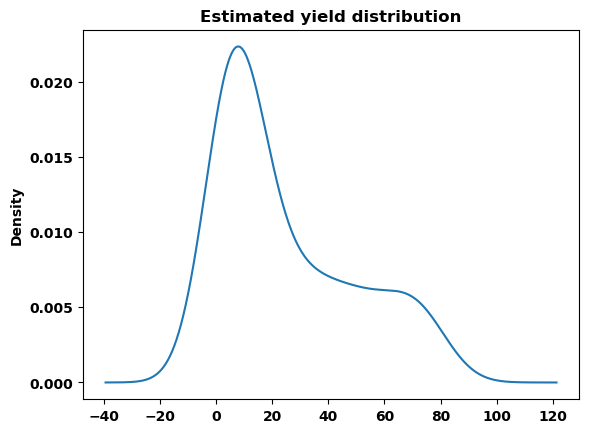

total_stress  estimated_yield  previous_stress  chill hours stress  \
year                                                                            
1924-1925      0.382897         5.435587         0.000000                 0.0   
1925-1926      0.264240         0.920270         0.076579                 0.0   
1926-1927      0.194146         8.926571         0.052848                 0.0   
1927-1928      0.720651         0.704201         0.038829                 0.0   
1928-1929      0.279142         9.558997         0.144130                 0.0   
...                 ...              ...              ...                 ...   
2019-2020      0.151168        17.122355         0.045612                 0.0   
2020-2021      0.709243        73.747246         0.030234                 0.0   
2021-2022      0.306449        11.188581         0.141849                 0.0   
2022-2023      0.175524        81.150131         0.061290                 0.0   
2023-2024      0.308906        17.653490         0.035105                 0.0   

           heat units stress  temperature stress  hydric stress  \
year                                                              
1924-1925                0.0                 0.0       0.000000   
1925-1926                0.0                 0.0       0.000000   
1926-1927                0.0                 0.0       0.000000   
1927-1928                0.0                 0.0       0.073215   
1928-1929                0.0                 0.0       0.000000   
...                      ...                 ...            ...   
2019-2020                0.0                 0.0       0.000000   
2020-2021                0.0                 0.0       0.052123   
2021-2022                0.0                 0.0       0.019734   
2022-2023                0.0                 0.0       0.000000   
2023-2024                0.0                 0.0       0.000000   

           mechanical stress  nutritional stress  green_stink_bug stress  ...  \
year                                                                      ...   
1924-1925           0.018692                 0.0                     0.0  ...   
1925-1926           0.083814                 0.0                     0.0  ...   
1926-1927           0.018944                 0.0                     0.0  ...   
1927-1928           0.026497                 0.0                     0.0  ...   
1928-1929           0.031536                 0.0                     0.0  ...   
...                      ...                 ...                     ...  ...   
2019-2020           0.014299                 0.0                     0.0  ...   
2020-2021           0.011527                 0.0                     0.0  ...   
2021-2022           0.005786                 0.0                     0.0  ...   
2022-2023           0.021971                 0.0                     0.0  ...   
2023-2024           0.031498                 0.0                     0.0  ...   

           May hydric stress  September hydric stress  avg_rh_april  pp_april  \
year                                                                            
1924-1925                0.0                 0.000000     74.566667      88.0   
1925-1926                0.0                 0.036411     62.400000      37.4   
1926-1927                0.0                 0.000000     40.500000       3.8   
1927-1928                0.0                 0.000000     40.500000       3.8   
1928-1929                0.0                 0.094666     65.966667      27.8   
...                      ...                      ...           ...       ...   
2019-2020                0.0                 0.000000     60.633333      69.0   
2020-2021                0.0                 0.000000     40.500000       3.8   
2021-2022                0.0                 0.000000     60.366667       9.8   
2022-2023                0.0                 0.000000     67.200000      66.0   
2023-2024                0.0                 0.000000     6

In [126]:
# Plot distribution grouped by year
import matplotlib.pyplot as plt
# Set x-axis label
df.estimated_yield.plot(kind="kde",xlabel="Estimated yield", title="Estimated yield distribution")
plt.show()

df_grouped = df.groupby("year").mean()
display(df_grouped)

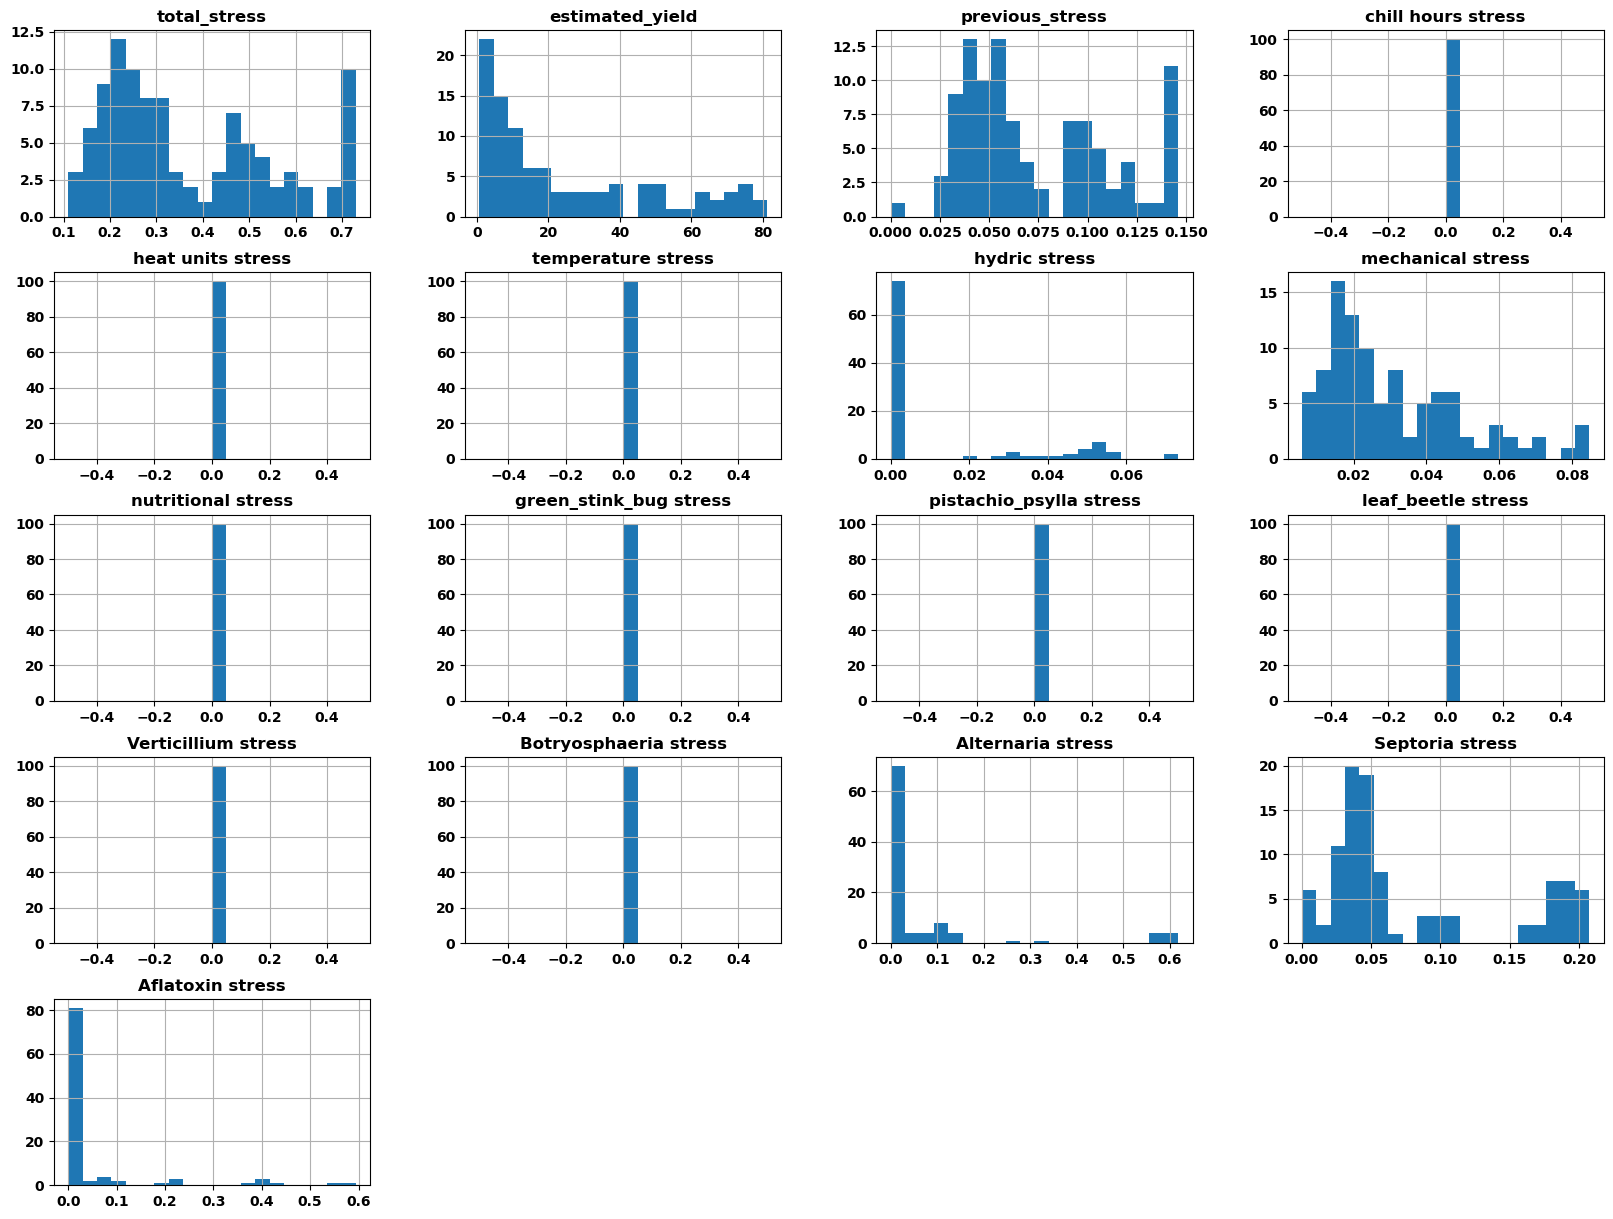

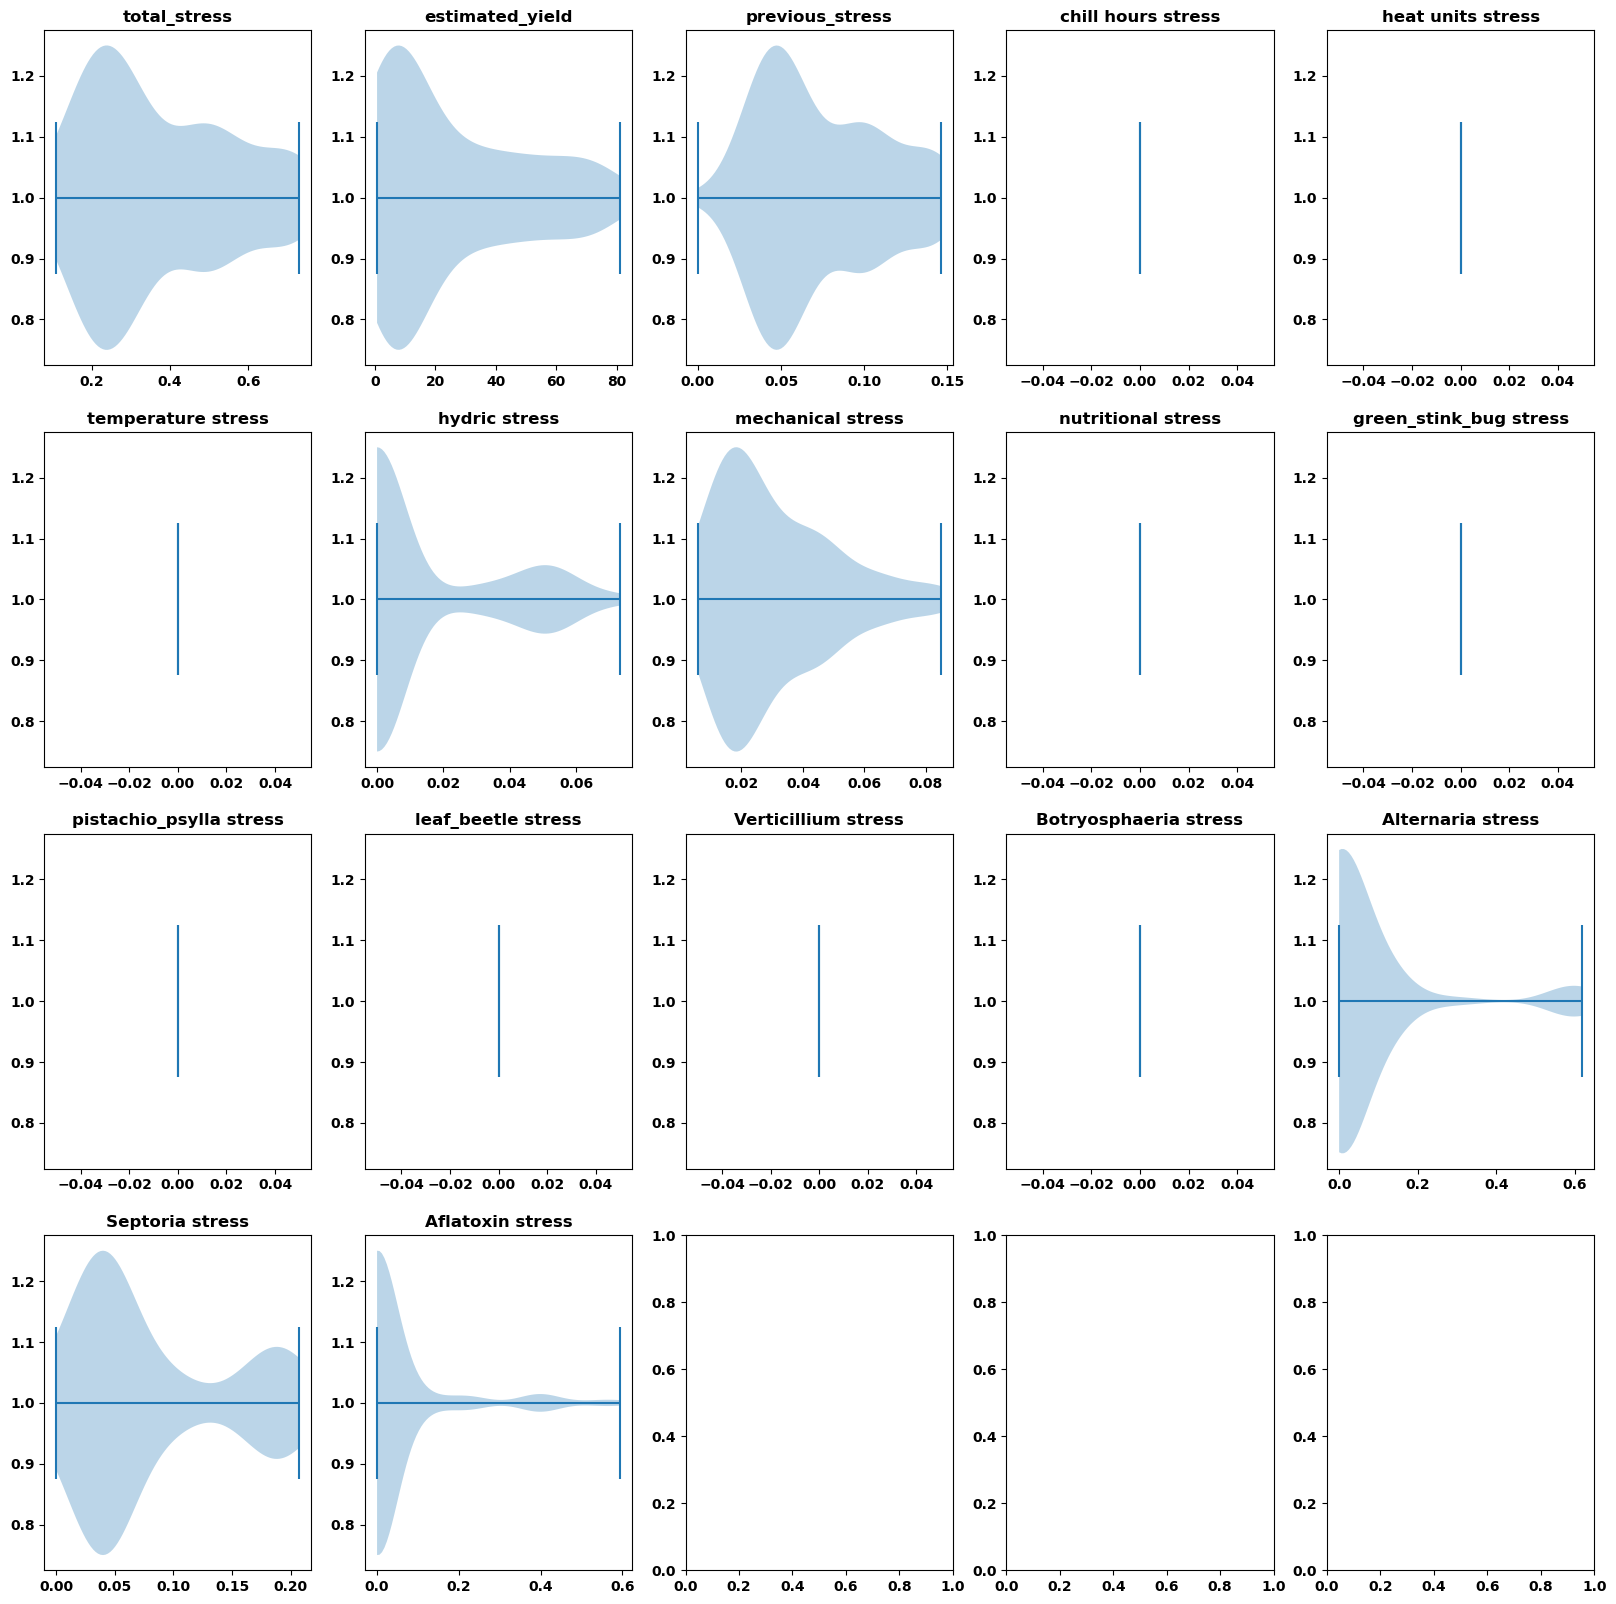

In [127]:
# Distribution of the estimated yield, total stress, previous stress, and stressors
import matplotlib.pyplot as plt

# Select only numeric columns
stress_df = df[["total_stress", "estimated_yield", "previous_stress", "chill hours stress", "heat units stress", "temperature stress", "hydric stress", "mechanical stress", "nutritional stress", PestType.green_stink_bug.name + " stress", PestType.pistachio_psylla.name + " stress", PestType.leaf_beetle.name + " stress", DiseaseType.Verticillium.name + " stress", DiseaseType.Botryosphaeria.name + " stress", DiseaseType.Alternaria.name + " stress", DiseaseType.Septoria.name + " stress", DiseaseType.Aflatoxin.name + " stress"]]

stress_df.hist(bins=20, figsize=(20,15))
plt.show()

# Boxplot of the estimated yield, total stress, previous stress, and stressors
# Do a 6x6 grid of boxplots
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, col in enumerate(stress_df.columns):
    axs[i//5, i%5].violinplot(stress_df[col].values, vert=False)
    axs[i//5, i%5].set_title(col)

### Correlation analysis

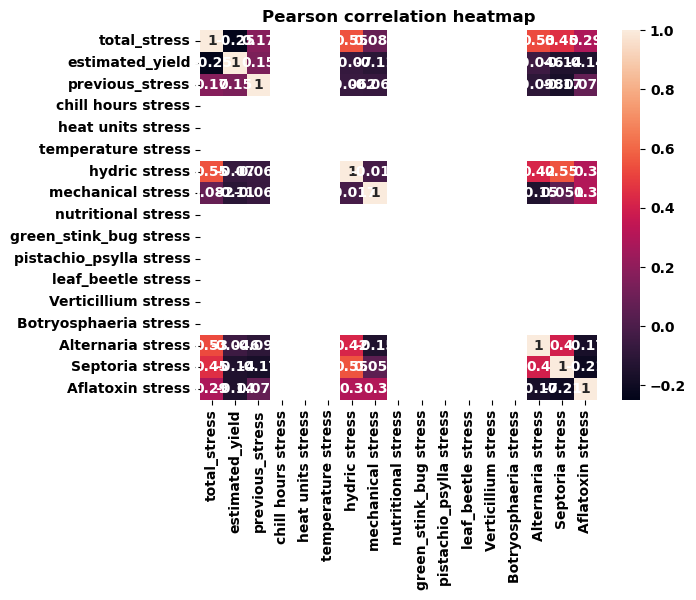

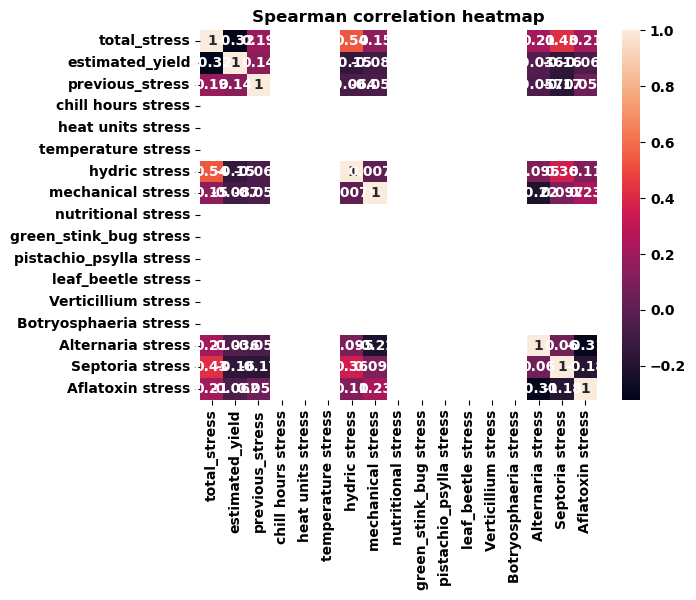

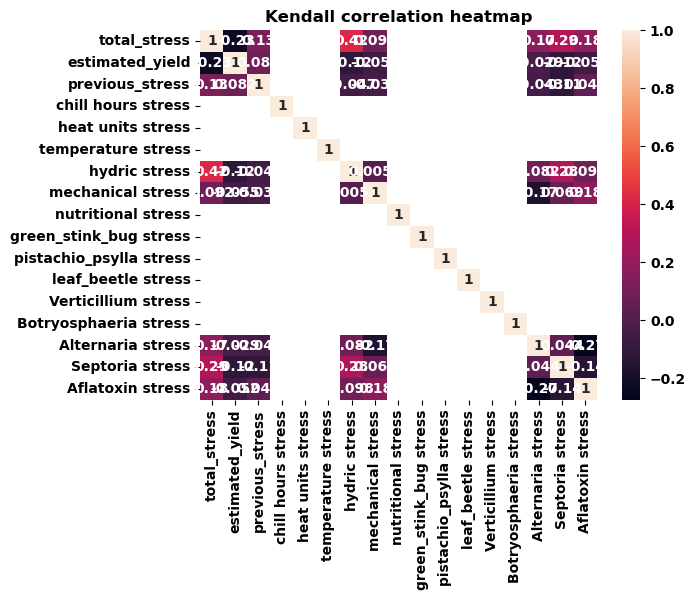

In [94]:
# Heatmap of the correlation between the variables
import seaborn as sns
sns.heatmap(stress_df.corr(method='pearson'), annot=True)
plt.title("Pearson correlation heatmap")
plt.show()
sns.heatmap(stress_df.corr(method='spearman'), annot=True)
plt.title("Spearman correlation heatmap")
plt.show()
sns.heatmap(stress_df.corr(method='kendall'), annot=True)
plt.title("Kendall correlation heatmap")
plt.show()

### Multicolinearity analysis

In [95]:
# Check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns and drop non-numeric ones
X = df.select_dtypes(include=['float64']).drop(columns=["estimated_yield"])

# Create DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)
vif_data

c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


feature         VIF
0              total_stress  129.266465
13        Alternaria stress   51.561646
15         Aflatoxin stress   38.681759
18  September hydric stress   30.999097
16      April hydric stress   30.610248
14          Septoria stress   11.005749
19             avg_rh_april    8.969792
22                  pp_sept    8.484661
20                 pp_april    6.742966
21                   pp_may    5.621776
17        May hydric stress    5.025487
5             hydric stress    4.552841
23                   avg_rh    4.428740
1           previous_stress    3.551921
6         mechanical stress    2.142398
25                     temp    0.144092
24                       pp    0.000000
2        chill hours stress         NaN
3         heat units stress         NaN
4        temperature stress         NaN
7        nutritional stress         NaN
8    green_stink_bug stress         NaN
9   pistachio_psylla stress         NaN
10       leaf_beetle stress         NaN
11      Verticillium stress         NaN
12    Botryosphaeria stress         NaN

In [96]:
# Remove values with high VIF
X = X.drop(columns=["avg_rh", "pp_april", "pp_may", "pp_sept", "avg_rh_april", "pistachio_psylla stress", "Verticillium stress"])
# Create DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)
vif_data

c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


feature         VIF
0              total_stress  101.659731
11        Alternaria stress   42.630440
13         Aflatoxin stress   28.838424
16  September hydric stress   24.357561
14      April hydric stress   18.046899
12          Septoria stress    8.934341
5             hydric stress    3.859688
1           previous_stress    2.964249
15        May hydric stress    2.944999
18                     temp    2.295918
6         mechanical stress    1.879314
17                       pp    0.000000
2        chill hours stress         NaN
3         heat units stress         NaN
4        temperature stress         NaN
7        nutritional stress         NaN
8    green_stink_bug stress         NaN
9        leaf_beetle stress         NaN
10    Botryosphaeria stress         NaN

## Feed an AI model with the data

Now that we have the best model possible for the real data, we can feed an AI model with the data to predict the yield of the pistachio crop in the future. We are going to test different models and compare the results. 

In [97]:
# Read from csv
import pandas as pd
df = pd.read_csv("results.csv")
df.tail(10)

year  total_stress  estimated_yield  previous_stress  \
90  2014-2015      0.257996        74.255630         0.054104   
91  2015-2016      0.439537         8.521396         0.051599   
92  2016-2017      0.296410        75.344122         0.087907   
93  2017-2018      0.212565        17.592310         0.059282   
94  2018-2019      0.228061        77.556205         0.042513   
95  2019-2020      0.151168        17.122355         0.045612   
96  2020-2021      0.709243        73.747246         0.030234   
97  2021-2022      0.306449        11.188581         0.141849   
98  2022-2023      0.175524        81.150131         0.061290   
99  2023-2024      0.308906        17.653490         0.035105   

    chill hours stress  heat units stress  temperature stress  hydric stress  \
90                 0.0                0.0                 0.0       0.000000   
91                 0.0                0.0                 0.0       0.000000   
92                 0.0                0.0                 0.0       0.028870   
93                 0.0                0.0                 0.0       0.000000   
94                 0.0                0.0                 0.0       0.000000   
95                 0.0                0.0                 0.0       0.000000   
96                 0.0                0.0                 0.0       0.052123   
97                 0.0                0.0                 0.0       0.019734   
98                 0.0                0.0                 0.0       0.000000   
99                 0.0                0.0                 0.0       0.000000   

    mechanical stress  nutritional stress  ...  May hydric stress  \
90           0.017129                 0.0  ...           0.062376   
91           0.071438                 0.0  ...           0.028372   
92           0.023343                 0.0  ...           0.000000   
93           0.012271                 0.0  ...           0.000000   
94           0.021701                 0.0  ...           0.000000   
95           0.014299                 0.0  ...           0.000000   
96           0.011527                 0.0  ...           0.000000   
97           0.005786                 0.0  ...           0.000000   
98           0.021971                 0.0  ...           0.000000   
99           0.031498                 0.0  ...           0.000000   

    September hydric stress  avg_rh_april  pp_april  pp_may  pp_sept  \
90                 0.000000     58.066667      14.8    54.6      3.0   
91                 0.000000     58.066667      14.8    54.6      3.0   
92                 0.028228     62.400000      37.4     2.8     32.0   
93                 0.000000     40.500000       3.8    30.7      0.4   
94                 0.000000     68.600000      67.4    49.8      6.6   
95                 0.000000     60.633333      69.0     7.6     19.0   
96                 0.000000     40.500000       3.8    30.7      0.4   
97                 0.000000     60.366667       9.8    22.8      0.0   
98                 0.000000     67.200000      66.0    46.4     25.4   
99                 0.000000     60.633333      69.0     7.6     19.0   

       avg_rh       pp       temp  is_on_year  
90  63.462185  35927.9  13.148896        True  
91  63.510145  35927.9  13.148896       False  
92  58.467422  35927.9  13.148896        True  
93  58.504202  35927.9  13.148896       False  
94  60.592896  35927.9  13.148896        True  
95  61.298630  35927.9  13.148896       False  
96  57.941176  35927.9  13.148896        True  
97  59.649315  35927.9  13.148896       False  
98  65.186301  35927.9  13.148896        True  
99  60.928767  35927.9  13.148896       False  

[10 rows x 29 columns]

In [98]:
test_size = 0.3
df_grouped = df.groupby("year").mean()
# Split the data into train and test (remove columns with high VIF)
data = df_grouped.copy().drop(columns=["avg_rh", "pp_april", "pp_may", "pp_sept", "avg_rh_april", "pistachio_psylla stress", "Verticillium stress"])
# Put estimated_yield at the end
data = data[[c for c in data if c not in ["estimated_yield"]] + ["estimated_yield"]]
data

total_stress  previous_stress  chill hours stress  \
year                                                           
1924-1925      0.382897         0.000000                 0.0   
1925-1926      0.264240         0.076579                 0.0   
1926-1927      0.194146         0.052848                 0.0   
1927-1928      0.720651         0.038829                 0.0   
1928-1929      0.279142         0.144130                 0.0   
...                 ...              ...                 ...   
2019-2020      0.151168         0.045612                 0.0   
2020-2021      0.709243         0.030234                 0.0   
2021-2022      0.306449         0.141849                 0.0   
2022-2023      0.175524         0.061290                 0.0   
2023-2024      0.308906         0.035105                 0.0   

           heat units stress  temperature stress  hydric stress  \
year                                                              
1924-1925                0.0                 0.0       0.000000   
1925-1926                0.0                 0.0       0.000000   
1926-1927                0.0                 0.0       0.000000   
1927-1928                0.0                 0.0       0.073215   
1928-1929                0.0                 0.0       0.000000   
...                      ...                 ...            ...   
2019-2020                0.0                 0.0       0.000000   
2020-2021                0.0                 0.0       0.052123   
2021-2022                0.0                 0.0       0.019734   
2022-2023                0.0                 0.0       0.000000   
2023-2024                0.0                 0.0       0.000000   

           mechanical stress  nutritional stress  green_stink_bug stress  \
year                                                                       
1924-1925           0.018692                 0.0                     0.0   
1925-1926           0.083814                 0.0                     0.0   
1926-1927           0.018944                 0.0                     0.0   
1927-1928           0.026497                 0.0                     0.0   
1928-1929           0.031536                 0.0                     0.0   
...                      ...                 ...                     ...   
2019-2020           0.014299                 0.0                     0.0   
2020-2021           0.011527                 0.0                     0.0   
2021-2022           0.005786                 0.0                     0.0   
2022-2023           0.021971                 0.0                     0.0   
2023-2024           0.031498                 0.0                     0.0   

           leaf_beetle stress  ...  Alternaria stress  Septoria stress  \
year                           ...                                       
1924-1925                 0.0  ...           0.000000         0.028632   
1925-1926                 0.0  ...           0.000000         0.097471   
1926-1927                 0.0  ...           0.088917         0.048114   
1927-1928                 0.0  ...           0.610162         0.173682   
1928-1929                 0.0  ...           0.000000         0.039384   
...                       ...  ...                ...              ...   
2019-2020                 0.0  ...           0.000000         0.054814   
2020-2021                 0.0  ...           0.606603         0.186579   
2021-2022                 0.0  ...           0.000000         0.170740   
2022-2023                 0.0  ...           0.000000         0.045297   
2023-2024                 0.0  ...           0.000000         0.195708   

           Aflatoxin stress  April hydric stress  May hydric stress  \
year                                                                  
1924-1925               0.0             0.352606                0.0   
1925-1926               0.0             0.000000                0.0   
1926-1927               0.0             0.000000                0.0   

In [122]:
# Functions
def metrics_and_plots(y_true, y_pred):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    # Metrics
    from sklearn.metrics import mean_squared_error, r2_score
    
    print(f"R2 score: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Mean absolute error: {round(np.mean(np.abs(y_true - y_pred)), 3)}")
    print(f"Root mean squared error: {round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)}")

    plt.figure(figsize=(23, 6))
    plt.title("Real test set vs Predicted test set")
    plt.plot(y_true.ravel(), label='Real test data')
    plt.plot(y_pred.ravel(), label='Predicted test data')
    plt.legend()
    plt.show()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title("Measured vs Predicted")
    plt.show()


def plot_residuals(y_test, y_pred):
    # Residuals qqplot
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    # Calculate residuals
    residuals = (y_test.ravel() - y_pred.ravel()).flatten()
    # Create figure
    fig = plt.figure(figsize=(10, 6))
    # QQ plot
    # Shapiro-Wilk test
    shapiro_test = stats.shapiro(residuals)
    print(f"Is normal distribution: {round(shapiro_test[1], 3)} > 0.05 = {shapiro_test[1] > 0.05}")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()
    
    # Additional residual plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Residuals vs Fitted
    ax1.scatter(y_pred.ravel(), residuals)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Fitted')
    
    # Residuals histogram
    ax2.hist(residuals, bins=30, edgecolor='black')
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of Residuals')
    
    plt.tight_layout()
    plt.show()



### Prepare the data

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Scale
scaler = StandardScaler()
# Drop NaN
data = data.dropna()
# Split data
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Split data into sequences of length n_steps_in. This is the sliding window approach
    where we use the last n_steps_in values to predict the next n_steps_out. In this case,
    we only need to predict the next value. You can uncommnet the `print(f'{seq_x} => {seq_y}')`
    statement to see the windows created and the corresponding output.
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+n_steps_out-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
        # print(f'{seq_x} => {seq_y}')
    return np.array(X), np.array(y)

X, y = split_sequence(data.values, 2, 1)
# Flatten
X = X.reshape((X.shape[0], -1))
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=42)
# Scale
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Predictive models implementation

Model: Ridge


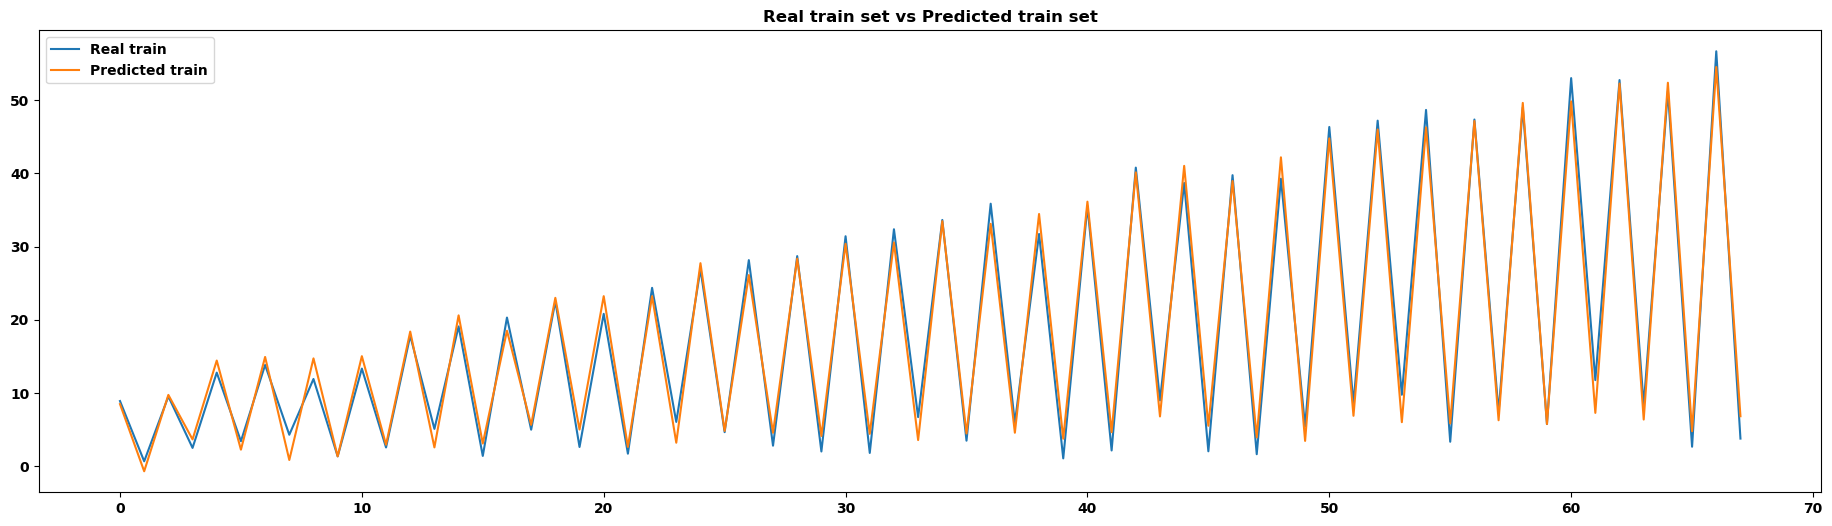

R2 score: 0.968
Mean absolute error: 4.539
Root mean squared error: 5.212


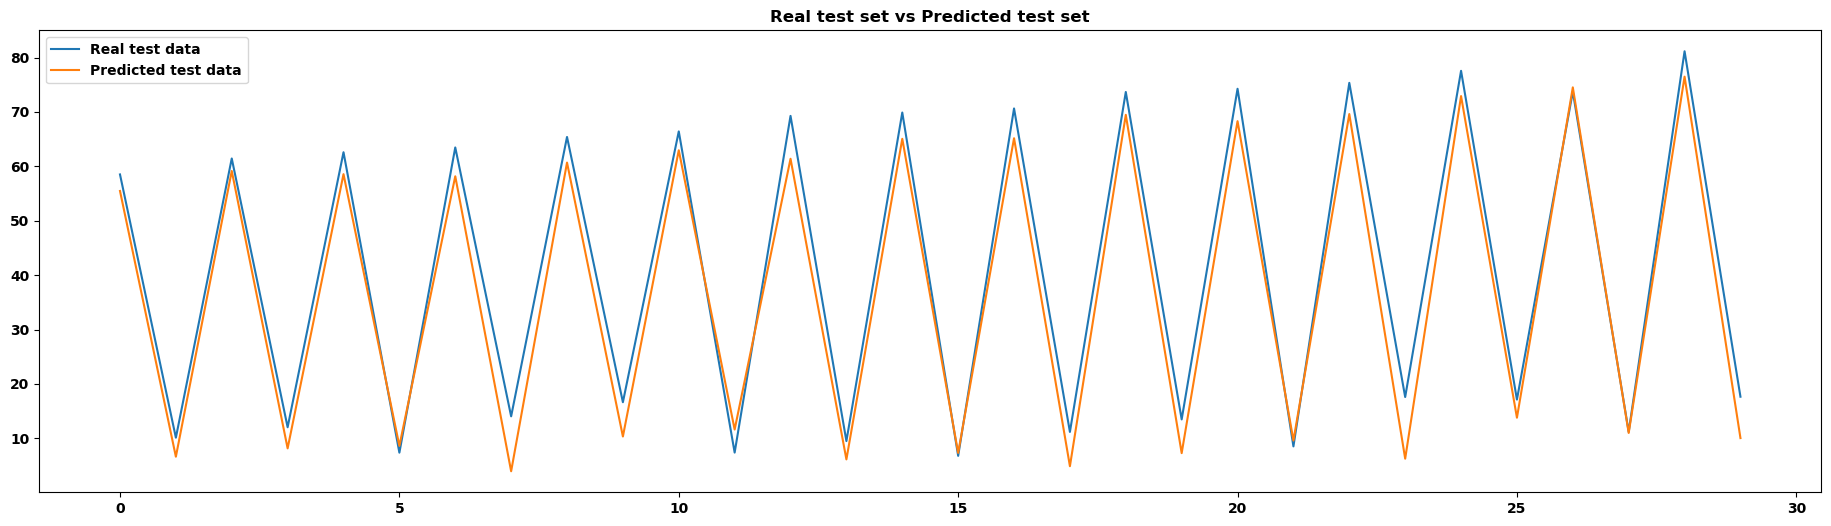

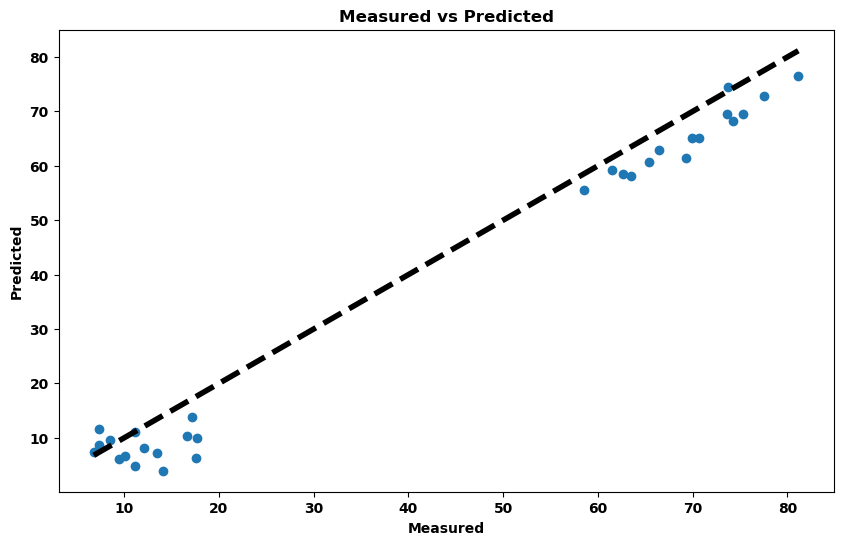

Is normal distribution: 0.33 > 0.05 = True


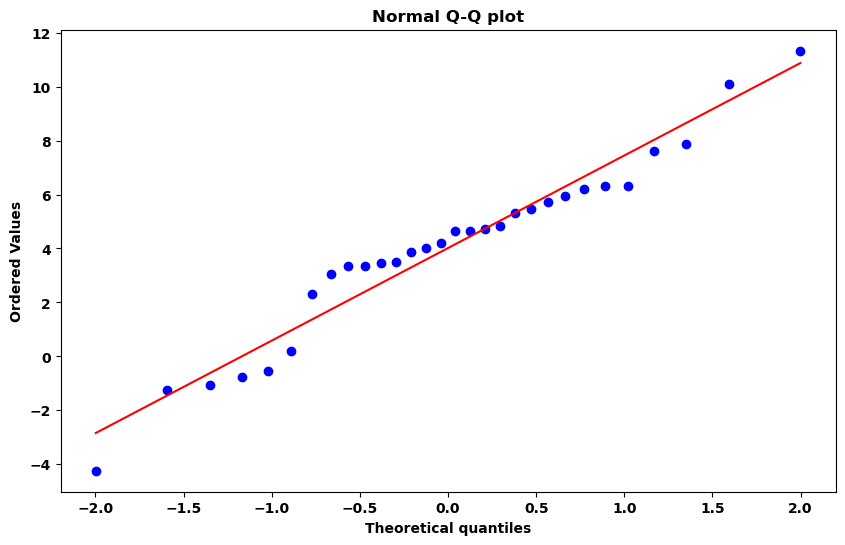

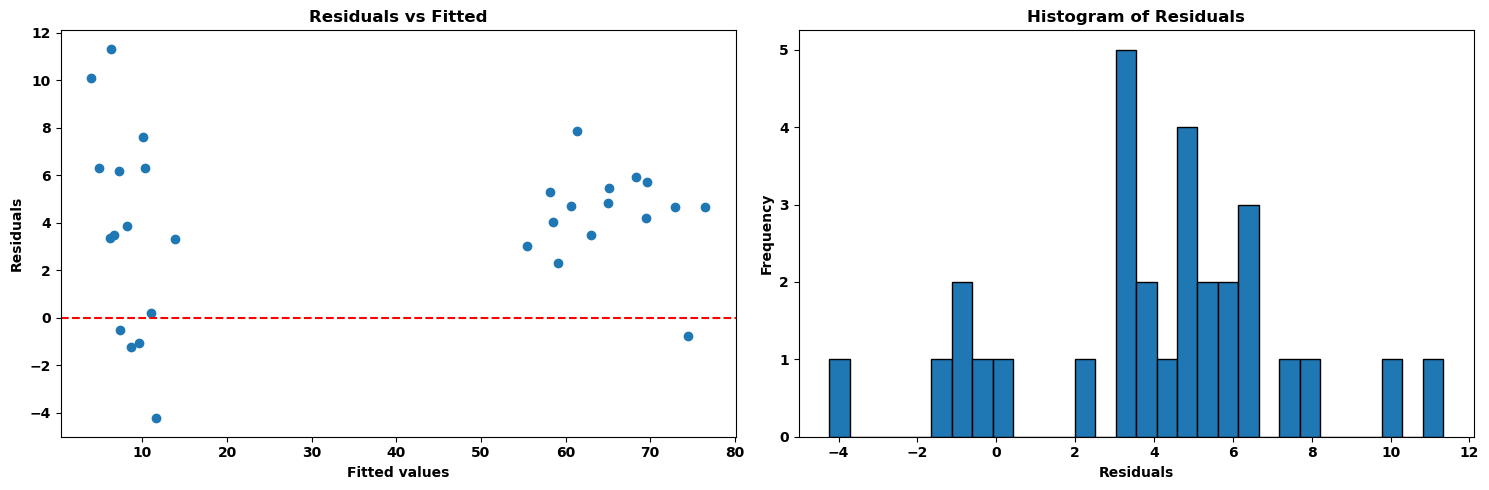

Model: RandomForest


c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


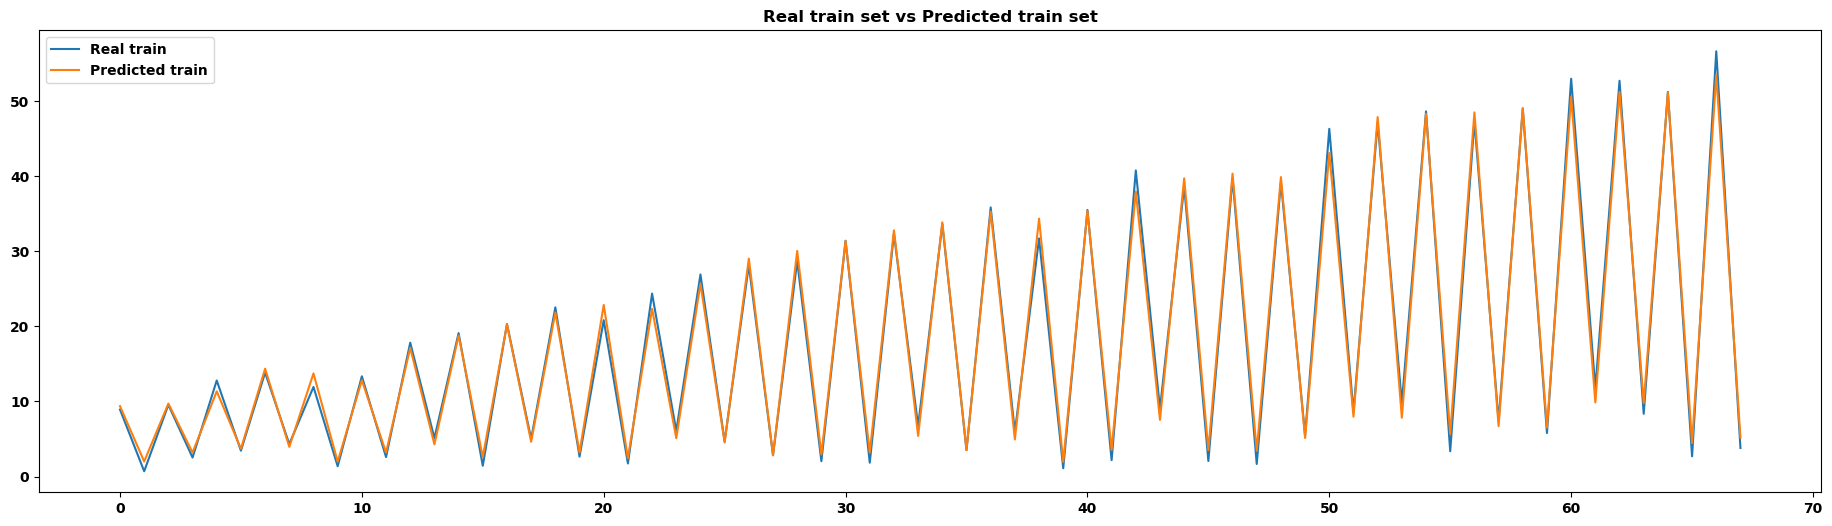

R2 score: 0.762
Mean absolute error: 11.526
Root mean squared error: 14.254


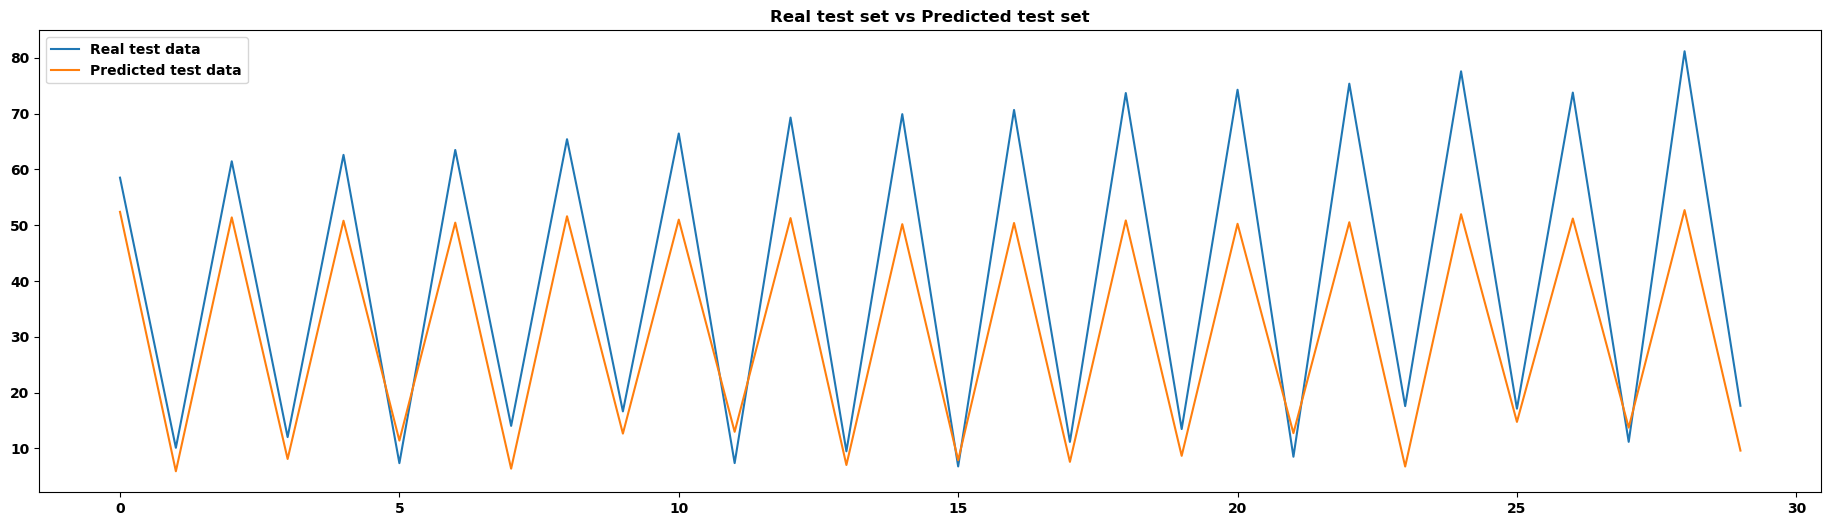

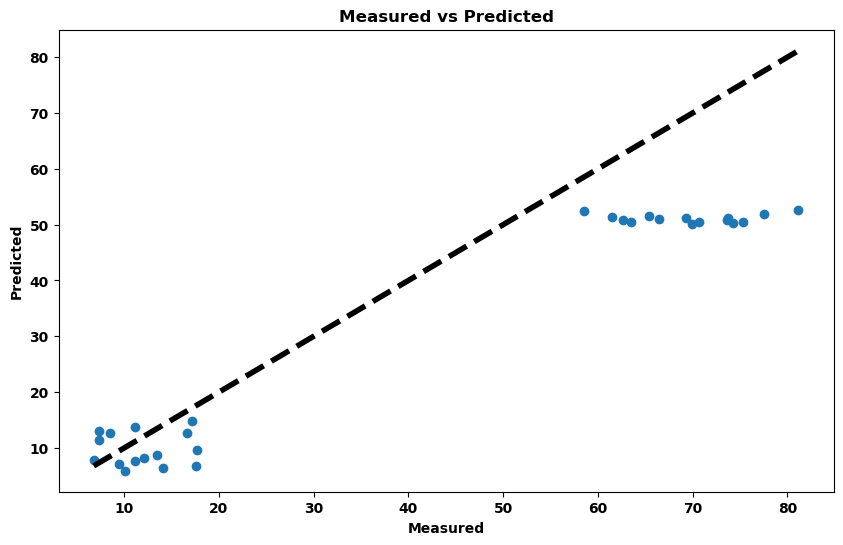

Is normal distribution: 0.212 > 0.05 = True


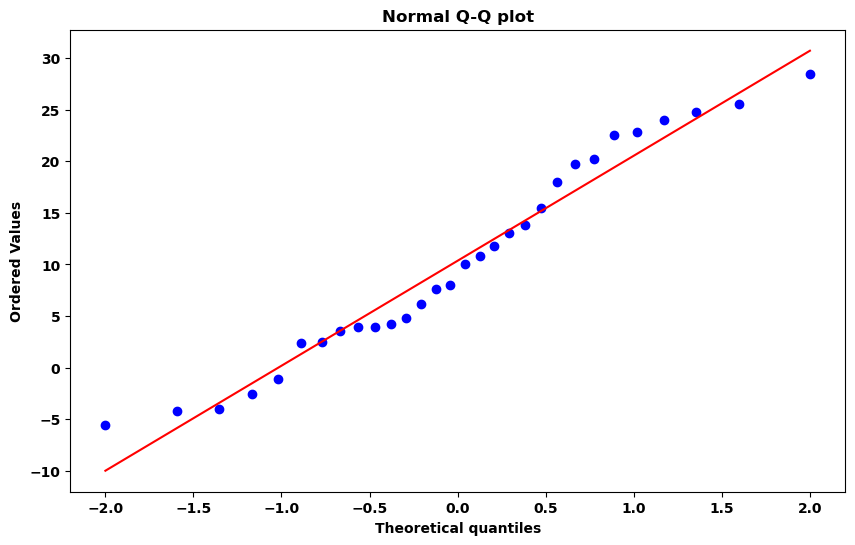

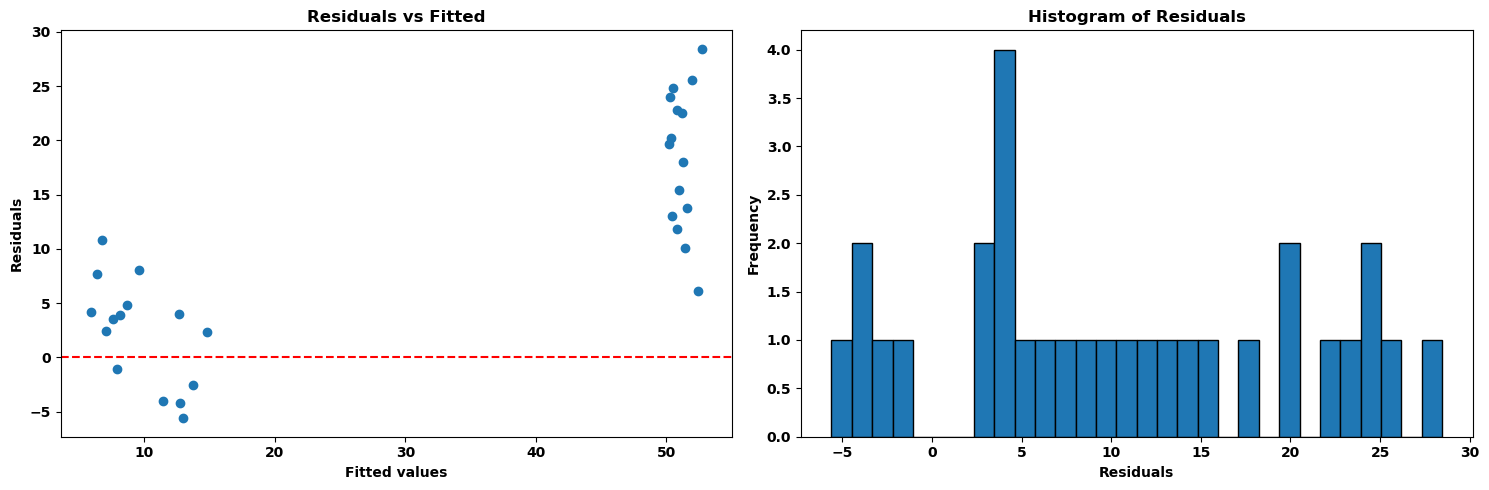

Model: BayesianRidge


c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


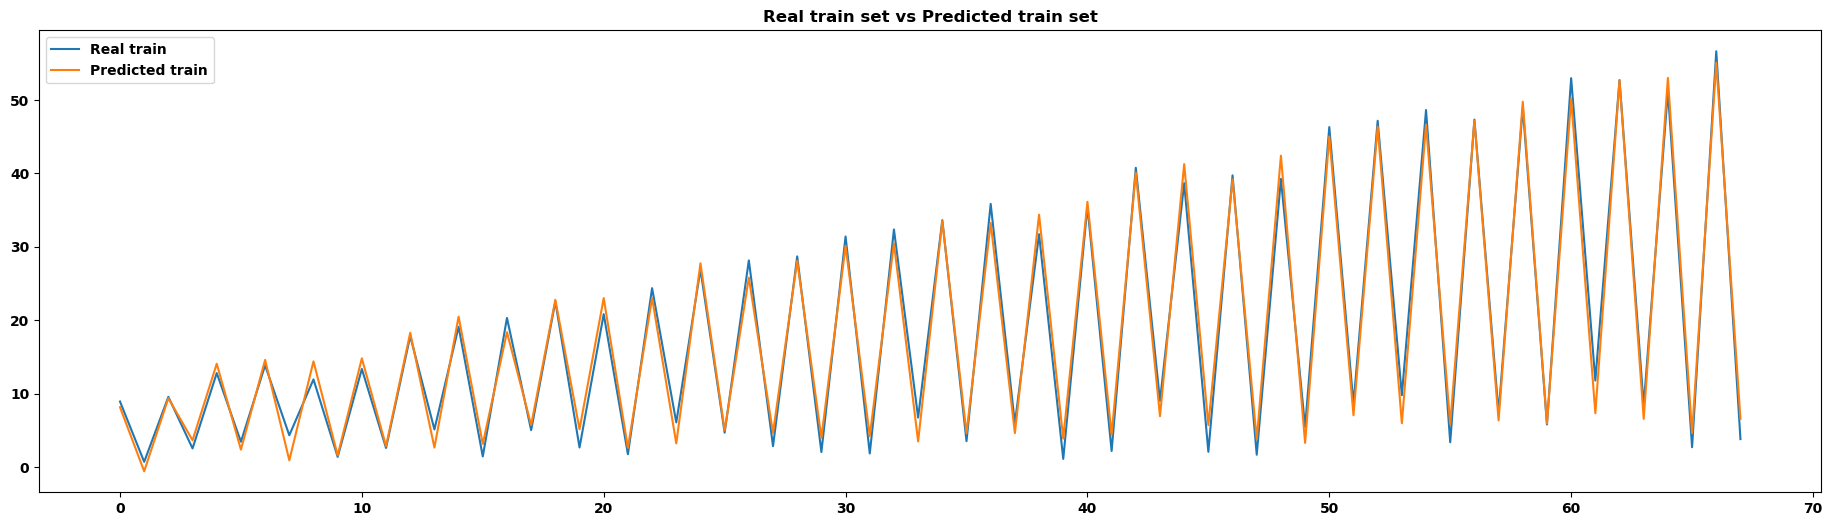

R2 score: 0.971
Mean absolute error: 4.238
Root mean squared error: 4.964


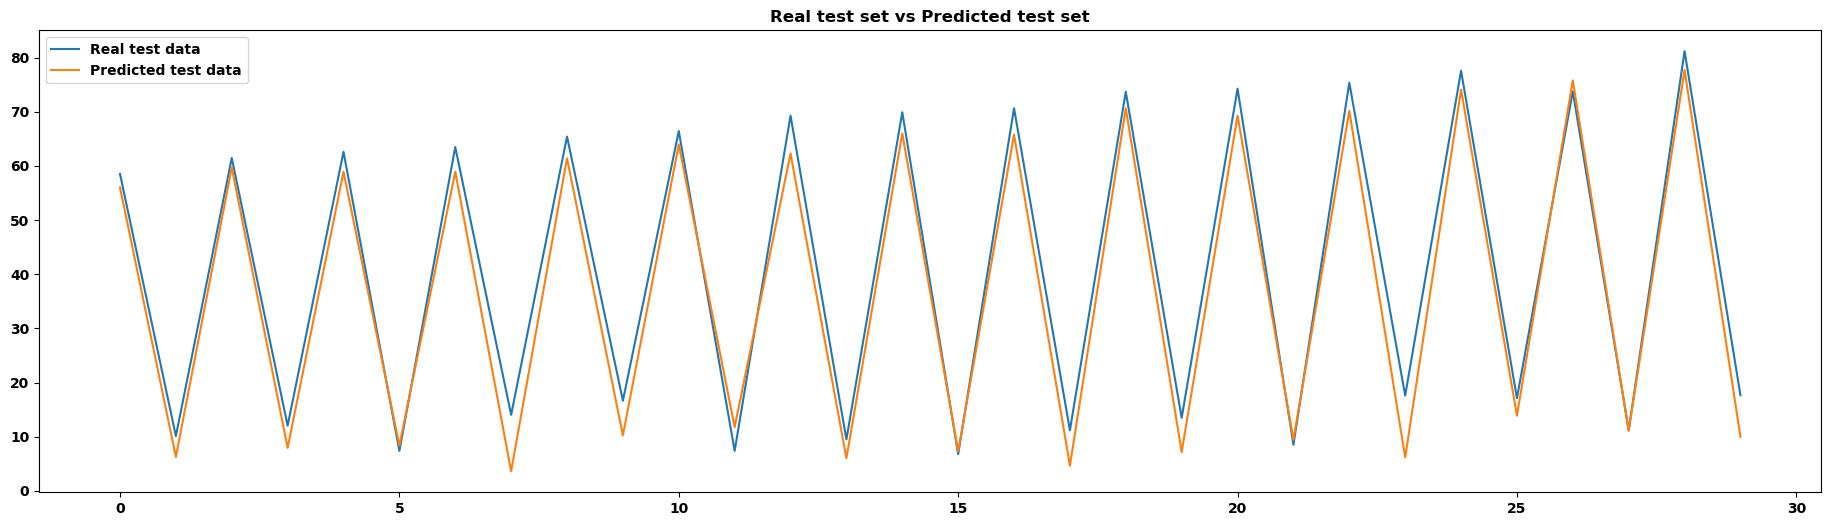

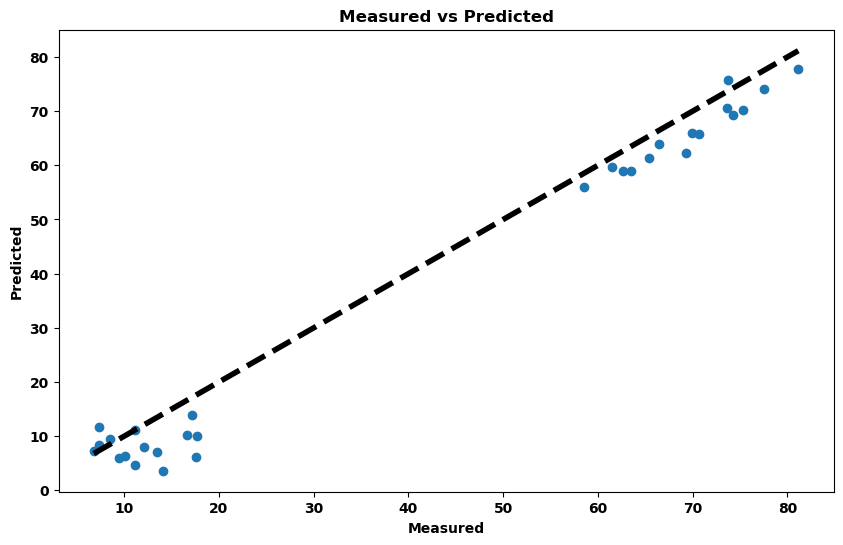

Is normal distribution: 0.506 > 0.05 = True


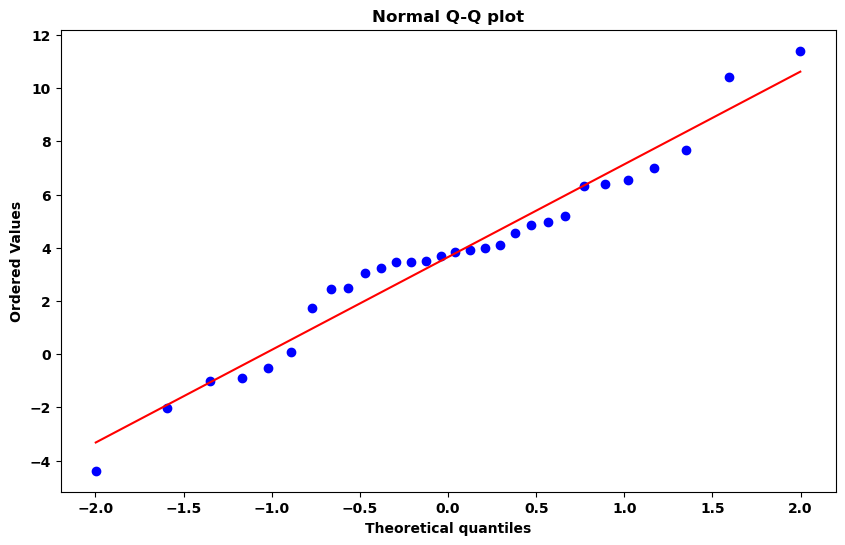

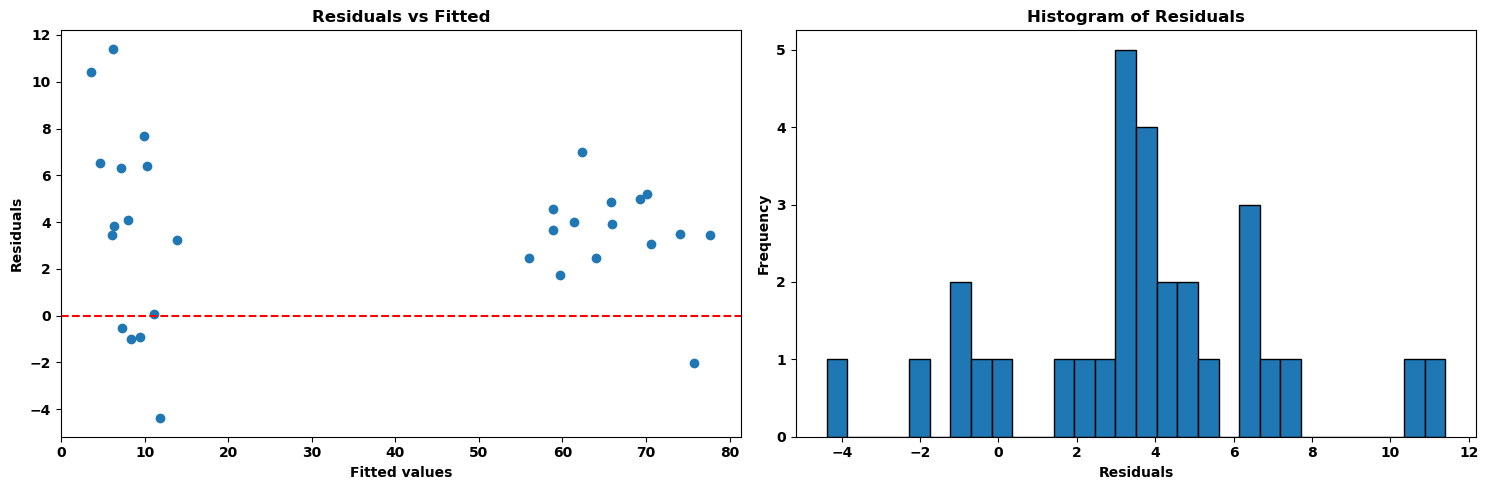

Model: MLP


c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jlagu\miniconda3\envs\pistachio-simulation\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


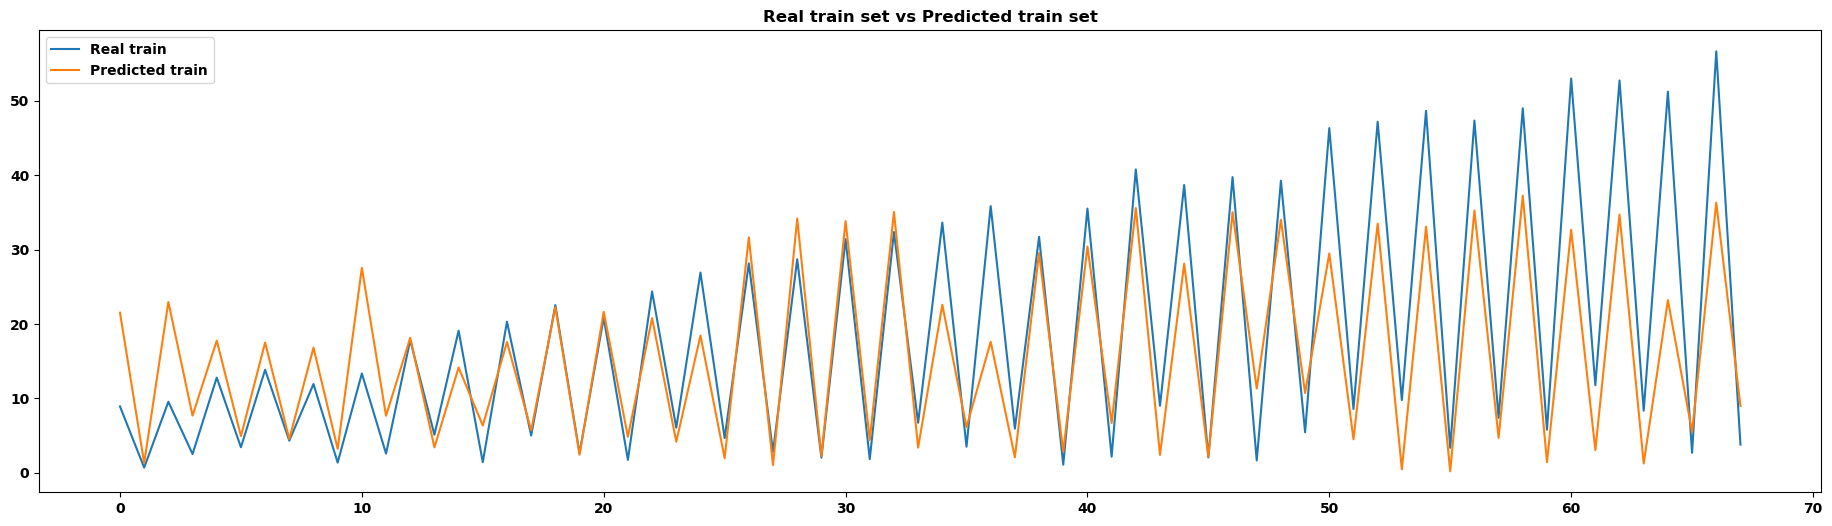

R2 score: -0.087
Mean absolute error: 25.316
Root mean squared error: 30.46


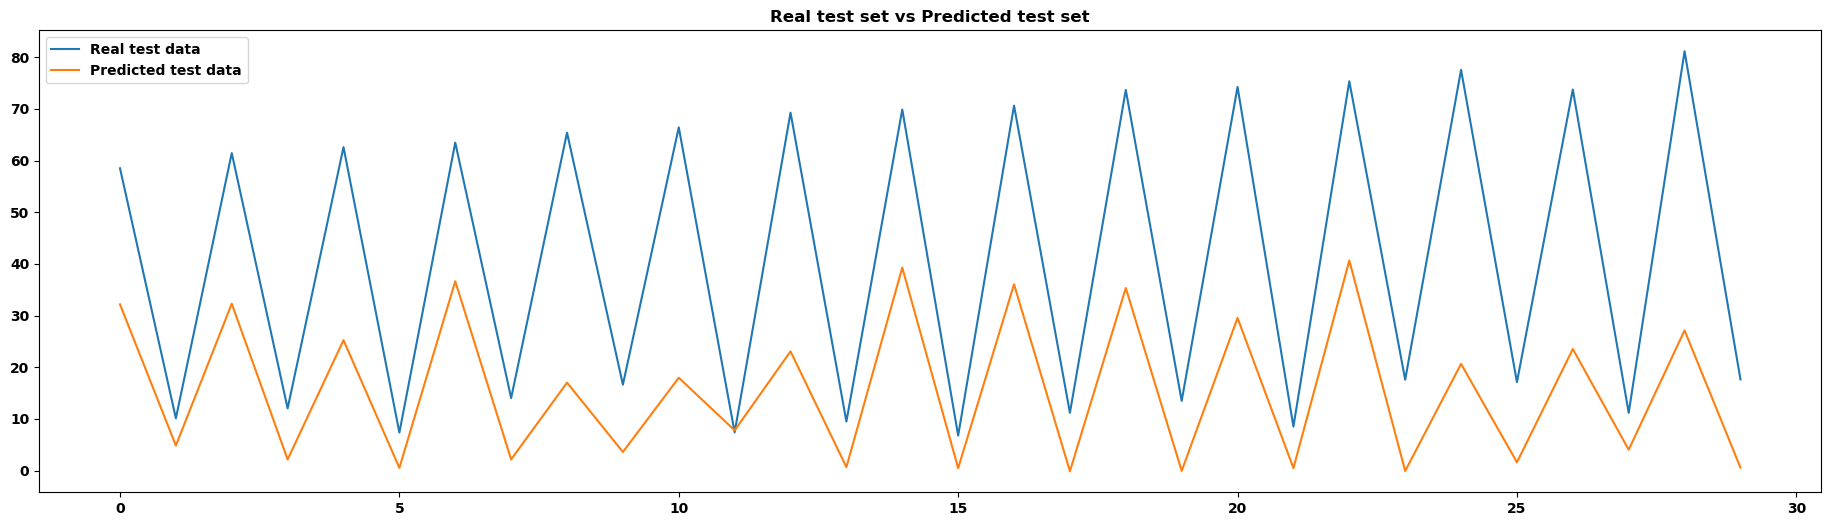

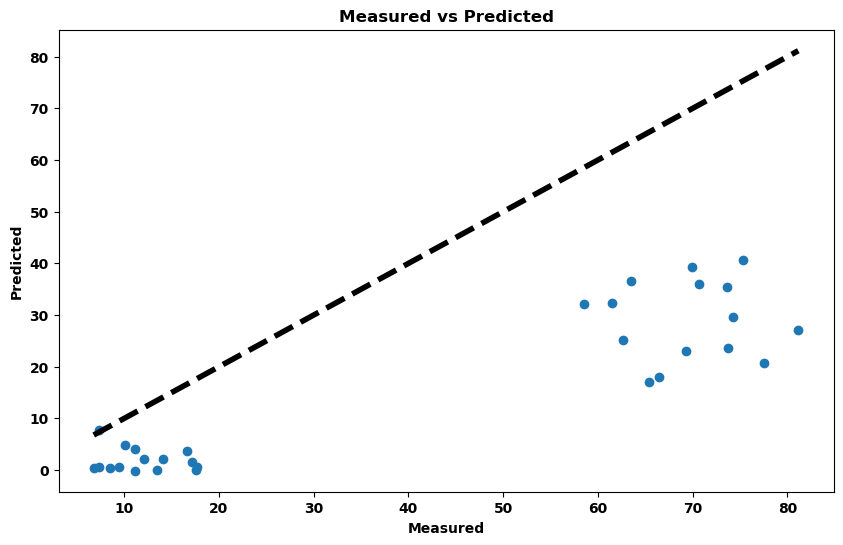

Is normal distribution: 0.026 > 0.05 = False


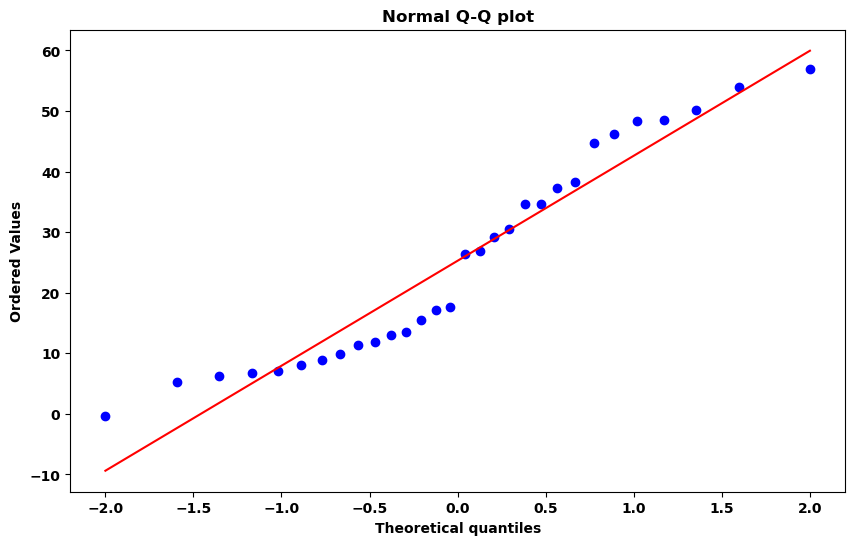

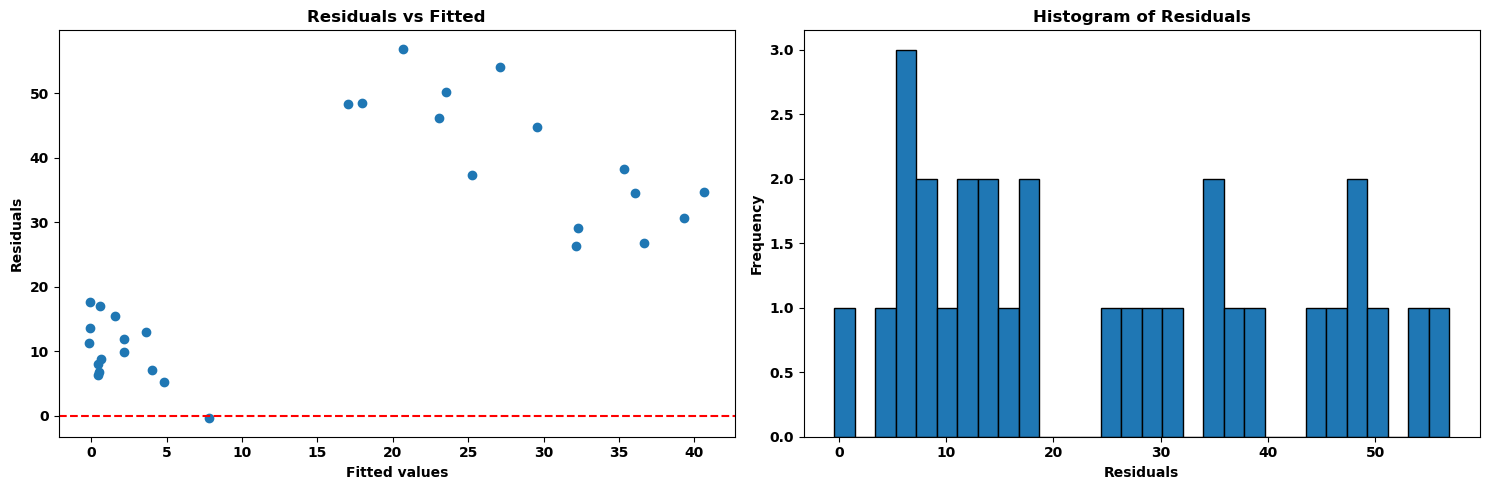

In [123]:
# Test different models
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge


models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=500),
    "BayesianRidge": BayesianRidge(),
    "MLP": MLPRegressor(),
}

for name, model in models.items():
    print(f"Model: {name}")
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Plot real vs predicted
    plt.figure(figsize=(23, 6))
    plt.title('Real train set vs Predicted train set')
    plt.plot(y_train.ravel(), label='Real train')
    plt.plot(y_pred_train.ravel(), label='Predicted train')
    plt.legend()
    plt.show()
    metrics_and_plots(y_test.ravel(), y_pred.ravel())
    plot_residuals(y_test, y_pred)